# Exploratory Data Analysis (EDA) of OpenML Datasets

This notebook presents an exploratory data analysis of datasets from OpenML. We will examine dataset descriptions, analyze word and sentence lengths, perform named entity recognition, POS tagging, and explore text similarity among dataset descriptions. We will also investigate the complexity of dataset descriptions, the distribution of tags, and the number of features in datasets. Finally, we will analyze the presence of URLs in dataset descriptions and explore the domains of these URLs.

In [1]:
import os
import re
from collections import Counter
from collections import defaultdict
from urllib.parse import urlparse

import gensim
import matplotlib.pyplot as plt
import nltk
import numpy as np
import openml
import pandas as pd
import plotly.express as px
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import seaborn as sns
import textstat
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from spacy import displacy
from tqdm import tqdm
from urlextract import URLExtract
from wordcloud import WordCloud, STOPWORDS

# Enable GPU support for spaCy
# os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

# spacy must be imported after setting the environment variable
import spacy

activated = spacy.prefer_gpu()

try:
    nlp = spacy.load("en_core_web_trf")
except OSError:
    !python -m spacy download en_core_web_trf
    nlp = spacy.load("en_core_web_trf")

# Disable truncation in pandas display of columns
pd.set_option('display.max_colwidth', None)

# Disable truncation in pandas display of rows 
# pd.set_option('display.max_rows', None)

/Users/ivang/miniconda3/envs/openml-tags/lib/python3.10/site-packages/textstat/textstat.py:7: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/Users/ivang/miniconda3/envs/openml-tags/lib/python3.10/site-packages/pkg_resources/__init__.py:3121: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('zope')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/Users/ivang/miniconda3/envs/openml-tags/lib/python3.10/site-packages/thinc/shims/pytorch.py:253: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpicklin

## Data Retrieval
Retrieving and listing all datasets from OpenML.

In [2]:
# datasets = openml.datasets.list_datasets()
# print(openml.datasets.list_datasets()[531])

# ids = list(datasets.keys())
# print("Number of datasets: ", len(ids))

# # Removing non-dataset entries 
# ids.remove(4537)
# ids.remove(4546)
# ids.remove(4562)

# # Fetching dataset
# datasets = openml.datasets.get_datasets(ids, download_data=False, download_qualities=False)
# datasets[0]

In [3]:
# df = pd.DataFrame([dataset.__dict__ for dataset in datasets])
# # Add the OpenML URL to the dataframe
# df['openml_url'] = [dataset.openml_url for dataset in datasets]
# df['upload_date'] = [dataset.upload_date for dataset in datasets]
# # All datasets which have None description, make it an empty string ""
# df['description'] = df['description'].fillna('')
# df

Save dataframe, so datasets aren't refetched every time.

In [4]:
# # save dataframe, so datasets aren't refetched every time, save everything as is, None don't get turned to NaN, etc.
# df.to_pickle("data/datasets.pkl")

Load datasets from the saved CSV

In [5]:
df = pd.read_pickle("data/datasets.pkl")
df

ignore_attribute  dataset_id         name  version  \
0                None           2       anneal        1   
1                None           3     kr-vs-kp        1   
2                None           4        labor        1   
3                None           5   arrhythmia        1   
4                None           6       letter        1   
...               ...         ...          ...      ...   
5674             None       46204    US-Births        1   
5675             None       46205  Solar-Power        1   
5676             None       46206   Wind-Power        1   
5677             None       46207   Wind-Power        2   
5678             None       46208     Banknote        1   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

## Initial Dataframe Creation
Creation of an initial dataframe for analysis, including URLs and descriptions.

In [6]:
import sys
from pathlib import Path

# Get the absolute path of the project root directory (go up one level from 'notebooks')
project_root = Path.cwd().parent
sys.path.append(str(project_root))

In [7]:
# import importlib

# from src.augmenters import tag_augmenter, feature_augmenter, dataset_augmenter, similarity_augmenter, name_augmenter, \
#     scrapy_augmenter, llm_prompt_augmenter

# importlib.reload(tag_augmenter)
from src.augmenters import TagAugmenter

# importlib.reload(feature_augmenter)
from src.augmenters import FeatureAugmenter

# importlib.reload(dataset_augmenter)
from src.augmenters import DatasetAugmenter

# importlib.reload(similarity_augmenter)
from src.augmenters import SimilarityAugmenter

# importlib.reload(name_augmenter)
from src.augmenters import NameAugmenter

# importlib.reload(scrapy_augmenter)
from src.augmenters import ScrapyAugmenter

# importlib.reload(llm_prompt_augmenter)
from src.augmenters import LLMPromptAugmenter

description_column = 'description'
dataset_id_column = 'dataset_id'
tag_column = 'tag'
features_column = '_features'
name_column = 'name'
augmented_column = 'augmented_description'
similar_datasets_column = 'similar_datasets'
scraped_column = 'scraped_data'
prompt_description_column = 'prompt_description'

augmenters = [
    TagAugmenter(description_column, tag_column, augmented_column, dataset_id_column, json_file_path=os.path.join(project_root, 'src', 'augmenters', 'GPT_semantic_tags.json')),
    NameAugmenter(description_column, name_column, augmented_column),
    FeatureAugmenter(description_column, features_column, augmented_column, max_features=100, reduce_features=True),
    ScrapyAugmenter(description_column, scraped_column, augmented_column),
    SimilarityAugmenter(description_column, augmented_column, similar_datasets_column),
    # Only load LLMPromptAugmenter if the datasets have been augmented with the LLM below in the code
    LLMPromptAugmenter(prompt_description_column)
]

dataset_augmenter = DatasetAugmenter(augmenters=augmenters)
augmented_df = dataset_augmenter.augment(df.copy())
augmented_df

ignore_attribute  dataset_id                 name  version  \
0                None           2               anneal        1   
1                None           3             kr-vs-kp        1   
2                None           4                labor        1   
3                None           5           arrhythmia        1   
4                None           6               letter        1   
...               ...         ...                  ...      ...   
5673             None       46203  Saugeen-River-Daily        1   
5674             None       46204            US-Births        1   
5675             None       46205          Solar-Power        1   
5676             None       46206           Wind-Power        1   
5678             None       46208             Banknote        1   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [8]:
# show augmented_df where scraped_data is not empty string
augmented_df[augmented_df[scraped_column] != ''][['dataset_id', 'name', 'original_data_url', 'description', 'scraped_data']]

dataset_id              name  \
0              2            anneal   
1              3          kr-vs-kp   
2              4             labor   
3              5        arrhythmia   
4              6            letter   
...          ...               ...   
5408       45736            libras   
5409       45737             yeast   
5412       45741             beans   
5417       45746  cardiotocography   
5421       45755             algae   

                                                            original_data_url  \
0                           https://archive.ics.uci.edu/ml/datasets/Annealing   
1     https://archive.ics.uci.edu/ml/datasets/Chess+(King-Rook+vs.+King-Pawn)   
2                     https://archive.ics.uci.edu/ml/datasets/Labor+Relations   
3                          https://archive.ics.uci.edu/ml/datasets/arrhythmia   
4                  https://archive.ics.uci.edu/ml/datasets/Letter+Recognition   
...                                                                       ...   
5408                  https://archive.ics.uci.edu/dataset/181/libras+movement   
5409                            https://archive.ics.uci.edu/dataset/110/yeast   
5412                 https://archive.ics.uci.edu/dataset/602/dry+bean+dataset   
5417                 https://archive.ics.uci.edu/dataset/193/cardiotocography   
5421       https://archive.ics.uci.edu/dataset/118/coil+1999+competition+data   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

### Description vs Augmented Description lengths

/Users/ivang/miniconda3/envs/openml-tags/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/ivang/miniconda3/envs/openml-tags/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/ivang/miniconda3/envs/openml-tags/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/ivang/miniconda3/envs/openml-tags/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  war

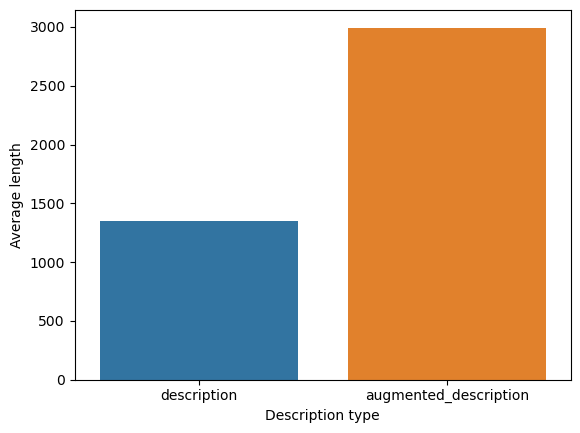

In [9]:
# plot length of combined 'description' column vs 'augmented_description' column
desc_len = df['description'].map(len)
aug_desc_len = augmented_df['augmented_description'].map(len)

# plot sns barplot one vs the other
sns.barplot(x=['description', 'augmented_description'],
            y=[desc_len.mean(), aug_desc_len.mean()],
            hue=['description', 'augmented_description'])
# x axis label
plt.xlabel('Description type')
# y axis label
plt.ylabel('Average length')
plt.savefig('../latex/thesis/figures/description_vs_augmented_description.pdf')
plt.show()

In [8]:
# Use the augmented descriptions for the rest of the notebook
augmented_df = augmented_df.drop(columns=['description'])
augmented_df = augmented_df.rename(columns={'augmented_description': 'description'})
df = augmented_df

In [11]:
# show df where similar datasets are not empty list
df[df[similar_datasets_column].map(len) > 0]

ignore_attribute  dataset_id                name  version cache_format  \
104              None         157   RandomRBF_10_1E-3        1       pickle   
106              None         159   RandomRBF_50_1E-3        1       pickle   
869              None        1027                 ESL        1       pickle   
1055             None        1351  BNG(anneal,1000,1)        1       pickle   
1058             None        1354  BNG(anneal,5000,1)        1       pickle   
...               ...         ...                 ...      ...          ...   
5597             None       46125  car_rental_process        1       pickle   
5644             None       46174               Flare        1       pickle   
5664             None       46194           seclogs_1        1       pickle   
5667             None       46197      firewall_logs1        1       pickle   
5676             None       46206          Wind-Power        1       pickle   

     format  \
104    ARFF   
106    ARFF   
869    ARFF   
1055   ARFF   
1058   ARFF   
...     ...   
5597   arff   
5644   arff   
5664   arff   
5667   arff   
5676   arff   

                                                                                                             creator  \
104                                                                                                             None   
106                                                                                                             None   
869                                                                                                      Yoav Ganzah   
1055                                        [Geoffrey Holmes, Bernhard Pfahringer, Jan van Rijn, Joaquin Vanschoren]   
1058                                        [Geoffrey Holmes, Bernhard Pfahringer, Jan van Rijn, Joaquin Vanschoren]   
...                                                                                                              ...   
5597                                                                                                            None   
5644                                                                                                            None   
5664                                                                                                            None   
5667                                                                                                           anjan   
5676  Godahewa, Rakshitha; Bergmeir, Christoph;  Webb, Geoff; Abolghasemi, Mahdi; Hyndman, Rob; Montero-Manso, Pablo   

     contributor      collection_date          upload_date  ... _qualities  \
104         None                 None  2014-04-10T02:47:05  ...       None   
106         None                 None  2014-04-10T02:49:06  ...       None   
869         None                 2005  2014-10-04T22:55:03  ...       None   
1055        None  2015-02-23 10:28:24  2015-02-22T22:29:46  ...       None   
1058        None  2015-02-23 10:37:07  2015-02-22T22:38:30  ...       None   
...          ...                  ...                  ...  ...        ...   
5597        None                 None  2024-06-03T22:13:53  ...       None   
5644        None                 None  2024-06-10T20:01:27  ...       None   
5664        None                 None  2024-06-14T10:51:02  ...       None   
5667        None                 None  2024-06-14T10:57:08  ...       None   
5676        None                 2020  2024-06-21T22:59:56  ...       None   

     _no_qualities_found data_pickle_file data_feather_file  \
104                False             None              None   
106                False             None              None   
869                False             None              None   
1055               False             None              None   
1058               False             None              None   
...                  ...              ...               ...   
5597               False             None              N

## Description Length Analysis

Analyzing the length of dataset descriptions.

<Axes: >

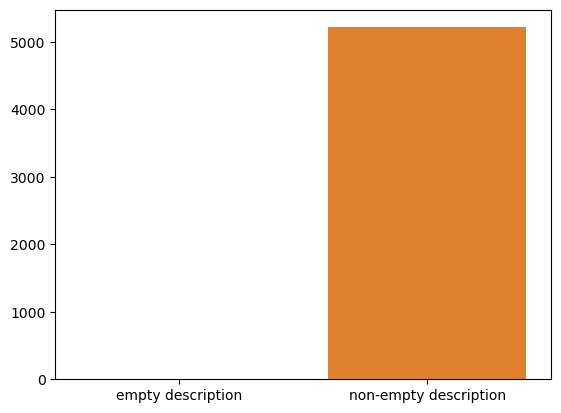

In [12]:
sns.barplot(x=['empty description', 'non-empty description'],
            y=[len(df[df['description'] == '']), len(df[df['description'] != ''])],
            hue=['empty description', 'non-empty description'])

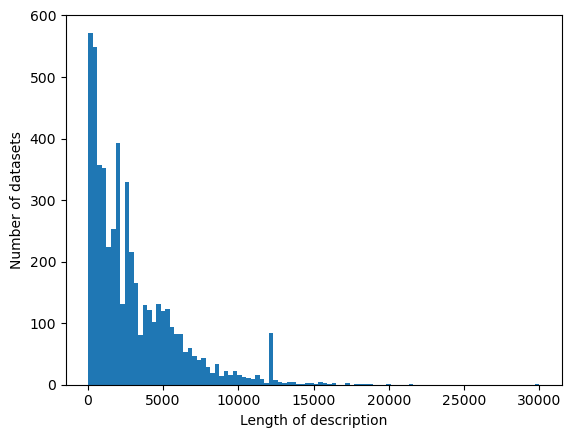

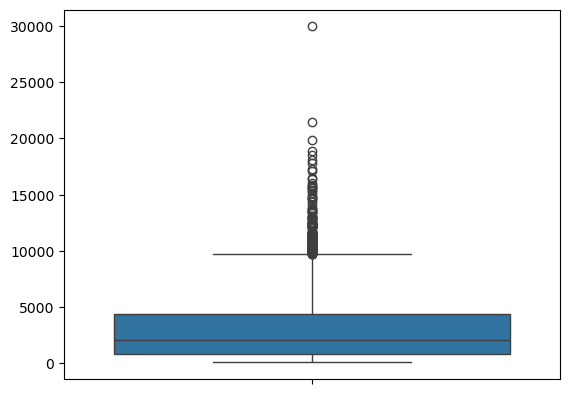

In [13]:
plt.hist([len(d) for d in df['description']], bins=100, color='C0')
plt.xlabel('Length of description')
plt.ylabel('Number of datasets')
plt.savefig('../latex/thesis/figures/length_of_descriptions.pdf')
plt.show()

sns.boxplot([len(d) for d in df['description']], color='C0')
plt.show()

## Filtering Long Descriptions

Filtering out datasets with unusually long descriptions for further inspection.

In [14]:
df[df['description'].map(len) > 9000]

ignore_attribute  dataset_id  \
3                  None           5   
5                  None           7   
20    [Hospital_Number]          25   
41                 None          49   
43                 None          51   
...                 ...         ...   
5266               None       45533   
5267               None       45534   
5268               None       45535   
5285               None       45559   
5287               None       45562   

                                                         name  version  \
3                                                  arrhythmia        1   
5                                                   audiology        1   
20                                                      colic        1   
41                                                    heart-c        1   
43                                                    heart-h        1   
...                                                       ...      ...   
5266  timing-attack-dataset-35-micro-seconds-delay-2022-09-19        1   
5267  timing-attack-dataset-35-micro-seconds-delay-2022-09-20        1   
5268  timing-attack-dataset-35-micro-seconds-delay-2022-09-21        1   
5285                                           COIL2000-train        1   
5287                                            seismic-bumps        3   

     cache_format format  \
3          pickle   ARFF   
5          pickle   ARFF   
20         pickle   ARFF   
41         pickle   ARFF   
43         pickle   ARFF   
...           ...    ...   
5266       pickle   arff   
5267       pickle   arff   
5268       pickle   arff   
5285       pickle   arff   
5287       pickle   arff   

                                                                      creator  \
3                         [H. Altay Guvenir, Burak Acar, Haldun Muderrisoglu]   
5                              Professor Jergen at Baylor College of Medicine   
20                                                [Mary McLeish, Matt Cecile]   
41    [Andras Janosi, William Steinbrunn, Matthias Pfisterer, Robert Detrano]   
43                                                                       None   
...                                                                       ...   
5266                                               Jan Drees and Dennis Funke   
5267                                               Jan Drees and Dennis Funke   
5268                                               Jan Drees and Dennis Funke   
5285                                                     Peter van der Putten   
5287                                                                     None   

               contributor collection_date          upload_date  ...  \
3                     None      1998-01-01  2014-04-06T23:19:36  ...   
5                     None      1987-12-03  2014-04-06T23:19:44  ...   
20                    None      1989-08-06  2014-04-06T23:21:15  ...   
41                    None      1988-07-01  2014-04-06T23:22:56  ...   
43                    None            None  2014-04-06T23:23:01  ...   
...                    ...             ...                  ...  ...   
5266          Pritha Gupta      2022-09-19  2023-05-30T15:29:12  ...   
5267          Pritha Gupta      2022-09-20  2023-05-30T15:29:20  ...   
5268          Pritha Gupta      2022-09-21  2023-05-30T15:29:26  ...   
5285  Peter van der Putten            2000  2023-06-05T09:59:31  ...   
5287                  None            None  2023-06-05T10:40:55  ...   

     _qualities _no_qualities_found data_pickle_file data_feather_file  \
3          None               False             None              None   
5          None               False             None              None   
20         None               False             None              None   
41         None               False             None              None   
43         None               False             None              None   
...         ...               

## Word and Sentence Analysis

Analyzing the word count and average sentence length in dataset descriptions.

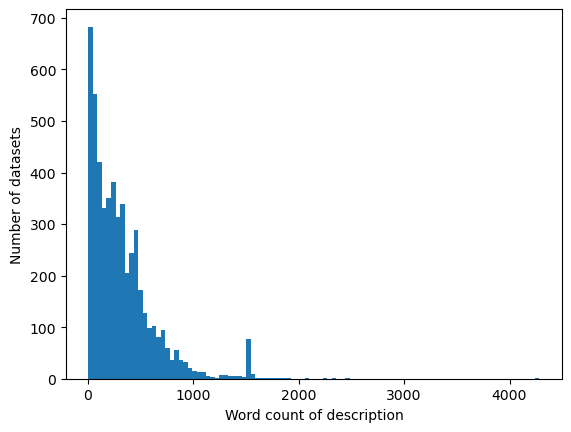

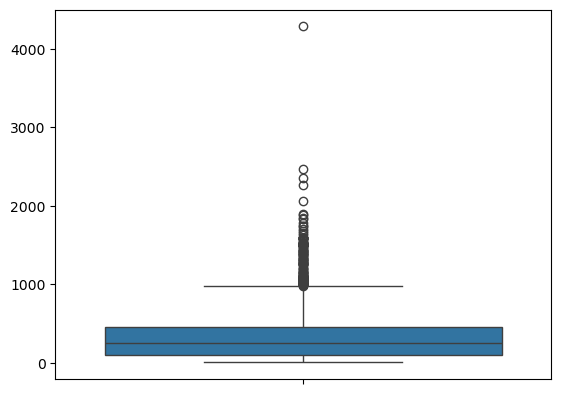

In [15]:
# Word count analysis
plt.hist([len(d.split()) for d in df['description']], bins=100, color='C0')
plt.xlabel('Word count of description')
plt.ylabel('Number of datasets')
plt.savefig('../latex/thesis/figures/words_of_descriptions.pdf')
plt.show()

sns.boxplot([len(d.split()) for d in df['description']], color='C0')
plt.show()

[nltk_data] Downloading package punkt to /Users/ivang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


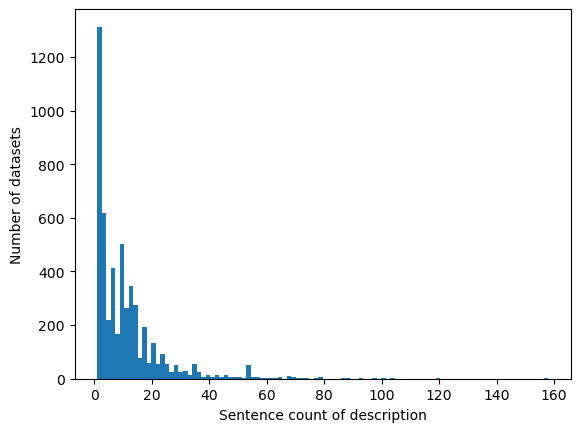

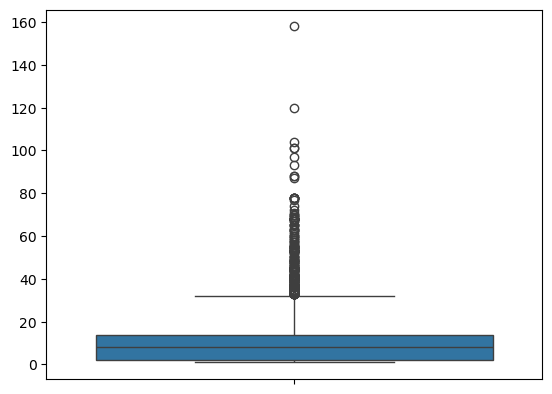

In [16]:
nltk.download('punkt')

plt.hist([len(tokenize.sent_tokenize(d)) for d in df['description']], bins=100, color='C0')
plt.xlabel('Sentence count of description')
plt.ylabel('Number of datasets')
plt.savefig('../latex/thesis/figures/sentences_of_descriptions.pdf')
plt.show()

sns.boxplot([len(tokenize.sent_tokenize(d)) for d in df['description']], color='C0')
plt.show()

## Mean Word Length Calculation

Computing the mean word length in dataset descriptions using spaCy for more accurate tokenization.

In [17]:
# Function to calculate mean word length
def mean_word_length(description):
    doc = nlp(description)
    words = [token.text for token in doc if not token.is_punct and not token.is_space]
    if words:  # Check if there are words to avoid ZeroDivisionError
        return sum(len(word) for word in words) / len(words)
    else:
        return 0


mean_word_lengths = df['description'].apply(mean_word_length)
print("Mean word lengths mean and median: ", mean_word_lengths.mean(), mean_word_lengths.median())

/Users/ivang/miniconda3/envs/openml-tags/lib/python3.10/site-packages/thinc/shims/pytorch.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self._mixed_precision):


Mean word lengths mean and median:  6.630394739089235 6.0986460677989225


Average word length in English texts is 5.1 characters


## Visualization of Mean Word Lengths

Displaying the distribution of mean word lengths across dataset descriptions.

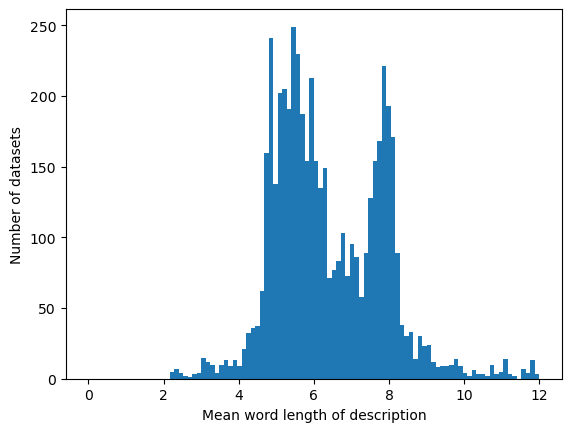

In [18]:
plt.hist(mean_word_lengths, bins=100, color='C0', range=(0, 12))
plt.xlabel('Mean word length of description')
plt.ylabel('Number of datasets')
plt.show()

## Longest Word in Descriptions

Identifying the longest words within dataset descriptions.

In [19]:
def longest_word(description):
    doc = nlp(description)
    words = [token.text for token in doc if not token.is_punct and not token.is_space]
    if words:  # Check if there are words to avoid ZeroDivisionError
        return max(words, key=len)
    else:
        return None


longest_words = df['description'].apply(longest_word)
longest_words.value_counts().head(10)

/Users/ivang/miniconda3/envs/openml-tags/lib/python3.10/site-packages/thinc/shims/pytorch.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self._mixed_precision):


description
https://www.dukascopy.com/swiss/english/marketwatch/historical/    192
binarized_regression_problem                                        85
DescriptionRelationshipAccessionSerine                              85
fri_colinearintydegree_samplenumber_featurenumber                   80
mythbusting_1                                                       80
https://github.com/LeoGrin/tabular-benchmark                        78
URL](https://www.bnlearn.com                                        77
Correctly_formatted_PKCS#1_PMS_message__but_1_byte_shorter          77
UCI](https://archive.ics.uci.edu                                    68
Acknowledgements                                                    61
Name: count, dtype: int64

## Term Frequency Analysis

Performing term frequency analysis to identify the most common words and phrases in dataset descriptions, excluding common stopwords.

In [10]:
nltk.download('stopwords')


# Function to clean and preprocess text
def clean(text, remove_stopwords=True, remove_numbers=True):
    text = text.lower()
    # Remove non-alphabetic characters
    text = re.sub('[^a-z A-Z 0-9-]+', '', text)
    # Remove stopwords
    if remove_stopwords:
        text = ' '.join([word for word in word_tokenize(text) if word not in stopwords.words('english')])
    # Remove numbers too
    if remove_numbers:
        text = re.sub(r'\d+', '', text)

    return text

[nltk_data] Downloading package stopwords to /Users/ivang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


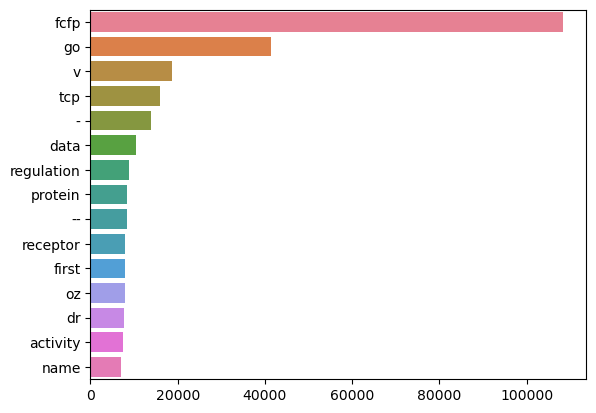

In [21]:
# Term frequency analysis for single words
mostCommon = Counter(word_tokenize(" ".join(df['description'].map(clean)))).most_common(15)
words = [word[0] for word in mostCommon]
frequency = [word[1] for word in mostCommon]

sns.barplot(x=frequency, y=words, hue=words)
plt.show()

## Topics Bar Chart
From before. Not dynamic
![Topics Bar Chart](../latex/proposal/images/topics_barchart.png)

## Bigram Frequency Analysis

Analyzing the frequency of bigrams (pairs of words) in dataset descriptions.

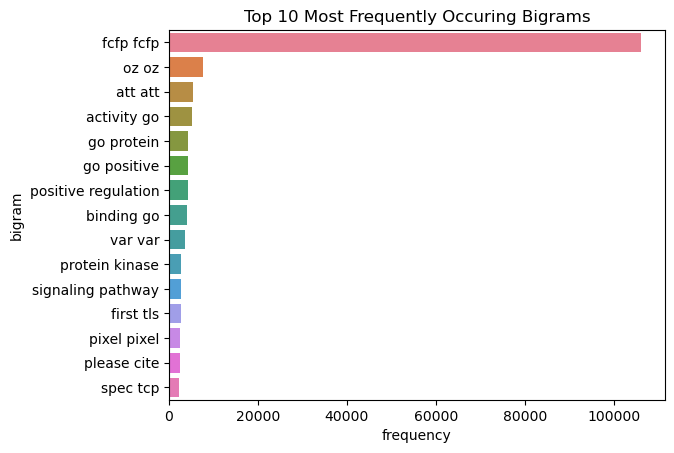

In [22]:
cv = CountVectorizer(ngram_range=(2, 2))
bigrams = cv.fit_transform(df['description'].map(clean))

count_values = bigrams.toarray().sum(axis=0)
bigram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse=True))
bigram_freq.columns = ["frequency", "bigram"]

sns.barplot(x=bigram_freq['frequency'][:15], y=bigram_freq['bigram'][:15], hue=bigram_freq['bigram'][:15])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

## Datasets Containing Specific Keywords

Filtering datasets that contain specific keywords such as 'TCP' within their descriptions.

In [23]:
df[df['description'].map(lambda x: 'tcp' in x)].head(50)

ignore_attribute  dataset_id  \
941              None        1110   
944              None        1113   
3233             None       42746   
5182             None       45449   
5183             None       45450   
5184             None       45451   
5194             None       45461   
5195             None       45462   
5196             None       45463   
5197             None       45464   
5198             None       45465   
5199             None       45466   
5200             None       45467   
5201             None       45468   
5202             None       45469   
5203             None       45470   
5204             None       45471   
5205             None       45472   
5206             None       45473   
5207             None       45474   
5208             None       45475   
5209             None       45476   
5210             None       45477   
5211             None       45478   
5212             None       45479   
5213             None       45480   
5214             None       45481   
5215             None       45482   
5216             None       45483   
5217             None       45484   
5218             None       45485   
5219             None       45486   
5220             None       45487   
5221             None       45488   
5222             None       45489   
5223             None       45490   
5224             None       45491   
5225             None       45492   
5226             None       45493   
5227             None       45494   
5228             None       45495   
5229             None       45496   
5230             None       45497   
5231             None       45498   
5232             None       45499   
5233             None       45500   
5235             None       45502   
5236             None       45503   
5237             None       45504   
5238             None       45505   

                                                          name  version  \
941                                              KDDCup99_full        1   
944                                                   KDDCup99        1   
3233                                                  KDDCup99        5   
5182    timing-attack-dataset-1-micro-seconds-delay-2022-09-01        1   
5183    timing-attack-dataset-1-micro-seconds-delay-2022-09-12        1   
5184    timing-attack-dataset-1-micro-seconds-delay-2022-09-17        1   
5194   timing-attack-dataset-16-micro-seconds-delay-2022-09-01        1   
5195   timing-attack-dataset-16-micro-seconds-delay-2022-09-12        1   
5196   timing-attack-dataset-16-micro-seconds-delay-2022-09-17        1   
5197   timing-attack-dataset-32-micro-seconds-delay-2022-09-01        1   
5198   timing-attack-dataset-32-micro-seconds-delay-2022-09-12        1   
5199   timing-attack-dataset-32-micro-seconds-delay-2022-09-17        1   
5200   timing-attack-dataset-64-micro-seconds-delay-2022-09-01        1   
5201   timing-attack-dataset-64-micro-seconds-delay-2022-09-12        1   
5202   timing-attack-dataset-64-micro-seconds-delay-2022-09-17        1   
5203  timing-attack-dataset-128-micro-seconds-delay-2022-09-01        1   
5204  timing-attack-dataset-128-micro-seconds-delay-2022-09-12        1   
5205  timing-attack-dataset-128-micro-seconds-delay-2022-09-17        1   
5206  timing-attack-dataset-256-micro-seconds-delay-2022-09-01        1   
5207  timing-attack-dataset-256-micro-seconds-delay-2022-09-12        1   
5208  timing-attack-dataset-256-micro-seconds-delay-2022-09-17        1   
5209   timing-attack-dataset-10-micro-seconds-delay-2022-09-04        1   
5210   timing-attack-dataset-10-micro-seconds-delay-2022-09-08        1   
5211   timing-attack-dataset-10-micro-seconds-delay-2022-09-09        1   
5212   timing-attack-dataset-10-micro-seconds-delay-2022-09-13        1   
5213   timing-attack-dataset-10-micro-seconds-delay-2022-09-14        1   
5214   timing-attack-dataset-10-micro-seconds-delay-2022-09-15        1   
5215   timing-att

## Trigram Frequency Analysis

Similar to bigram analysis, examining the frequency of trigrams (three-word sequences).

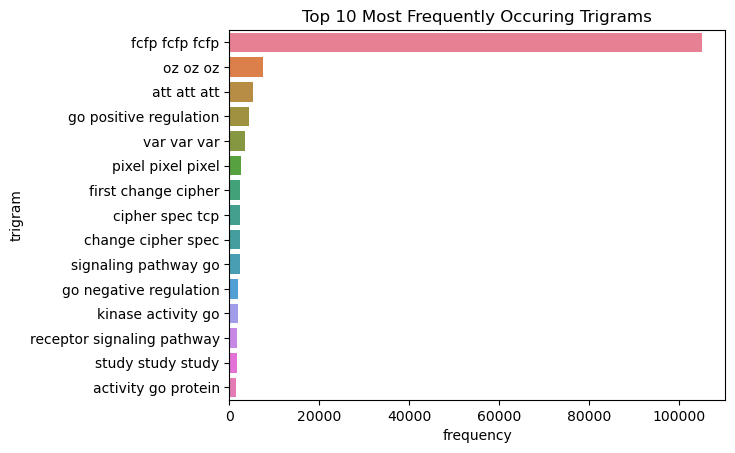

In [24]:
cv = CountVectorizer(ngram_range=(3, 3))
trigrams = cv.fit_transform(df['description'].map(clean))

count_values = trigrams.toarray().sum(axis=0)
trigram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse=True))
trigram_freq.columns = ["frequency", "trigram"]

sns.barplot(x=trigram_freq['frequency'][:15], y=trigram_freq['trigram'][:15], hue=trigram_freq['trigram'][:15])
plt.title('Top 10 Most Frequently Occuring Trigrams')
plt.show()

## Exploring Original Data URLs

Investigating the presence and domains of original data URLs in the dataset descriptions.

## Domain Analysis of URLs

Analyzing the domains of URLs found in the descriptions and visualizing the top domains.

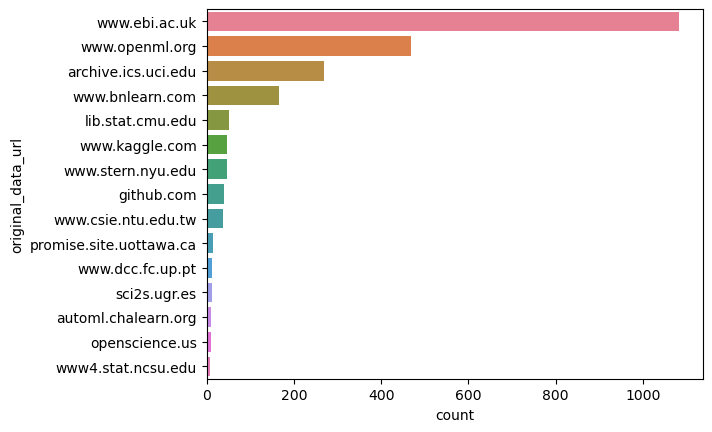

In [25]:
domains = (df['original_data_url'].dropna().map(lambda x: urlparse(x).netloc))

k = 15
sns.barplot(x=domains.value_counts().head(k), y=domains.value_counts().head(k).index,
            hue=domains.value_counts().head(k).index)
plt.show()


## Filtering Datasets by Domain

Filtering datasets with URLs from specific domains such as 'ebi.ac.uk' and 'github'.

In [26]:
df[df['original_data_url'].map(lambda x: 'ebi.ac.uk' in x if x else False)][
    ['name', 'original_data_url', 'openml_url']]

name                                       original_data_url  \
1277   QSAR-TID-12276  https://www.ebi.ac.uk/chembl/target/inspect/CHEMBL3956   
1278   QSAR-TID-12475  https://www.ebi.ac.uk/chembl/target/inspect/CHEMBL3848   
1279   QSAR-TID-12886  https://www.ebi.ac.uk/chembl/target/inspect/CHEMBL2731   
1280   QSAR-TID-10113  https://www.ebi.ac.uk/chembl/target/inspect/CHEMBL2978   
1281   QSAR-TID-12514   https://www.ebi.ac.uk/chembl/target/inspect/CHEMBL319   
...               ...                                                     ...   
2354   QSAR-TID-30004  https://www.ebi.ac.uk/chembl/target/inspect/CHEMBL3938   
2355   QSAR-TID-10803  https://www.ebi.ac.uk/chembl/target/inspect/CHEMBL3187   
2356   QSAR-TID-12327  https://www.ebi.ac.uk/chembl/target/inspect/CHEMBL3295   
2357   QSAR-TID-10962  https://www.ebi.ac.uk/chembl/target/inspect/CHEMBL2460   
2358  QSAR-TID-101276  https://www.ebi.ac.uk/chembl/target/inspect/CHEMBL5657   

                         openml_url  
1277  https://www.openml.org/d/3040  
1278  https://www.openml.org/d/3041  
1279  https://www.openml.org/d/3042  
1280  https://www.openml.org/d/3043  
1281  https://www.openml.org/d/3044  
...                             ...  
2354  https://www.openml.org/d/4127  
2355  https://www.openml.org/d/4128  
2356  https://www.openml.org/d/4129  
2357  https://www.openml.org/d/4130  
2358  https://www.openml.org/d/4131  

[1082 rows x 3 columns]

In [27]:
df[df['original_data_url'].map(lambda x: 'lib.stat.cmu' in x if x else False)][
    ['name', 'original_data_url', 'openml_url']]

name                          original_data_url  \
313                      irish  http://lib.stat.cmu.edu/datasets/irish.ed   
332                      profb     http://lib.stat.cmu.edu/datasets/profb   
347                    papir_2          http://lib.stat.cmu.edu/datasets/   
348              colleges_aaup          http://lib.stat.cmu.edu/datasets/   
351                newton_hema          http://lib.stat.cmu.edu/datasets/   
365                    nflpass          http://lib.stat.cmu.edu/datasets/   
371              baseball-team          http://lib.stat.cmu.edu/datasets/   
377                       pm10          http://lib.stat.cmu.edu/datasets/   
392                     houses          http://lib.stat.cmu.edu/datasets/   
402                        no2          http://lib.stat.cmu.edu/datasets/   
403                    strikes          http://lib.stat.cmu.edu/datasets/   
406                    detroit          http://lib.stat.cmu.edu/datasets/   
407                     kidney          http://lib.stat.cmu.edu/datasets/   
521            chscase_census5          http://lib.stat.cmu.edu/datasets/   
522            chscase_census4          http://lib.stat.cmu.edu/datasets/   
523            chscase_census3          http://lib.stat.cmu.edu/datasets/   
524            chscase_census2          http://lib.stat.cmu.edu/datasets/   
525             chscase_demand          http://lib.stat.cmu.edu/datasets/   
526          visualizing_slope          http://lib.stat.cmu.edu/datasets/   
527      disclosure_x_tampered          http://lib.stat.cmu.edu/datasets/   
528  visualizing_environmental          http://lib.stat.cmu.edu/datasets/   
529           rmftsa_sleepdata          http://lib.stat.cmu.edu/datasets/   
530              chscase_funds          http://lib.stat.cmu.edu/datasets/   
531             hutsof99_logis          http://lib.stat.cmu.edu/datasets/   
532              sleuth_ex2016          http://lib.stat.cmu.edu/datasets/   
533              sleuth_ex2015          http://lib.stat.cmu.edu/datasets/   
534                   rabe_166          http://lib.stat.cmu.edu/datasets/   
535      visualizing_livestock          http://lib.stat.cmu.edu/datasets/   
536         rmftsa_ctoarrivals          http://lib.stat.cmu.edu/datasets/   
537              sleuth_ex1605          http://lib.stat.cmu.edu/datasets/   
538           visualizing_soil          http://lib.stat.cmu.edu/datasets/   
539              chscase_vine2          http://lib.stat.cmu.edu/datasets/   
540         visualizing_galaxy          http://lib.stat.cmu.edu/datasets/   
541              chscase_vine1          http://lib.stat.cmu.edu/datasets/   
542                   rabe_131          http://lib.stat.cmu.edu/datasets/   
543            diggle_table_a1          http://lib.stat.cmu.edu/datasets/   
544            diggle_table_a2          http://lib.stat.cmu.edu/datasets/   
546     hutsof99_child_witness          http://lib.stat.cmu.edu/datasets/   
547                    rabe_97          http://lib.stat.cmu.edu/datasets/   
548                   rabe_176          http://lib.stat.cmu.edu/datasets/   
549               disclosure_z          http://lib.stat.cmu.edu/datasets/   
551              sleuth_ex1221          http://lib.stat.cmu.edu/datasets/   
552               chscase_foot          http://lib.stat.cmu.edu/datasets/   
553         disclosure_x_noise          http://lib.stat.cmu.edu/datasets/   
554             chscase_health          http://lib.stat.cmu.edu/datasets/   
555            sleuth_case1202          http://lib.stat.cmu.edu/datasets/   
556            sleuth_case1201          http://lib.stat.cmu.edu/datasets/   
557        visualizing_hamster          http://lib.stat.cmu.edu/datasets/   
558          disclosure_x_bias          http://lib.stat.cmu.edu/datasets/   
559                   rabe_148          http://lib.stat.cmu.edu/datasets/   
560        visualizing_ethanol          http://lib.stat.cmu.edu/datasets/   
561            chscase

In [28]:
df[df['original_data_url'].map(lambda x: 'github' in x if x else False)][['name', 'original_data_url', 'openml_url']]


name  \
2509                     Fashion-MNIST   
2560                      freMTPL2freq   
2567                      okcupid-stem   
2845                    MultilingualDS   
2878                   Kuzushiji-MNIST   
2884                      Kuzushiji-49   
2947                 article_influence   
2962                    dating_profile   
3101                    Midwest_Survey   
3102            Midwest_Survey_nominal   
3131                          penguins   
3190                ricci_vs_destefano   
3228                      okcupid-stem   
3242                    Midwest_survey   
3450                 ACSPublicCoverage   
3451                 ACSPublicCoverage   
3455      StackOverflow-polarity-train   
3456       StackOverflow-polarity-test   
3457            StackOverflow-polarity   
3463            StackOverflow-polarity   
5010                MTPL_SHAP_Tutorial   
5180                         AfriSenti   
5503             M4-competition-yearly   
5504          M4-competition-quarterly   
5505            M4-competition-monthly   
5506             M4-competition-weekly   
5507              M4-competition-daily   
5572             M4-competition-hourly   
5576        tourism-competition-yearly   
5583     tourism-competition-quarterly   
5584       tourism-competition-monthly   
5607              Cancer_Drug_Response   
5608              Cancer_Drug_Response   
5609   Cancer_Drug_Response_expression   
5610  Cancer_Drug_Response_methylation   
5611     Cancer_Drug_Response_mutation   
5612   Cancer_Drug_Response_copynumber   
5655                     Vehicle-Trips   
5662                    Covid19-global   
5663                        Covid19-us   
5671   Rainfall-Temperature-Aus-hourly   
5673               Saugeen-River-Daily   
5674                         US-Births   

                                                                                                         original_data_url  \
2509                                                                      https://github.com/zalandoresearch/fashion-mnist   
2560                                                                                https://github.com/dutangc/CASdatasets   
2567                                               https://github.com/rudeboybert/JSE_OkCupid/blob/master/profiles.csv.zip   
2845          https://github.com/valeriano-manassero/multilingual-text-categorization-dataset/blob/master/data/dataset.csv   
2878                                                                                   https://github.com/rois-codh/kmnist   
2884                                                                                   https://github.com/rois-codh/kmnist   
2947                             https://github.com/FlourishOA/Data/raw/master/estimated-article-influence-scores-2015.csv   
2962                                                https://github.com/rudeboybert/JSE_OkCupid/raw/master/profiles.csv.zip   
3101                                                     https://github.com/fivethirtyeight/data/tree/master/region-survey   
3102                                                     https://github.com/fivethirtyeight/data/tree/master/region-survey   
3131                                                                        https://github.com/allisonhorst/palmerpenguins   
3190                           https://github.com/algofairness/fairness-comparison/blob/master/fairness/data/raw/ricci.txt   
3228                                               https://github.com/rudeboybert/JSE_OkCupid/blob/master/profiles.csv.zip   
3242                               https://raw.githubusercontent.com/fivethirtyeight/data/master/region-survey/MIDWEST.csv   
3450                                             https://arxiv.org/pdf/2108.04884.pdf, https://github.com/zykls/folktables   
3451                                             https://arxiv.org/pdf/2108.04884.pdf, https://github.com/zykls/folktables   
3455                                       

In [29]:
df[df['original_data_url'].map(lambda x: 'bnlearn' in x if x else False)][['name', 'original_data_url', 'openml_url']]


name  \
5012   alarm_0   
5013   alarm_1   
5014   alarm_2   
5015   alarm_3   
5016   alarm_4   
...        ...   
5172   munin_6   
5173   munin_7   
5174   munin_8   
5175   munin_9   
5176  munin_10   

                                                     original_data_url  \
5012   https://www.bnlearn.com/bnrepository/discrete-medium.html#alarm   
5013   https://www.bnlearn.com/bnrepository/discrete-medium.html#alarm   
5014   https://www.bnlearn.com/bnrepository/discrete-medium.html#alarm   
5015   https://www.bnlearn.com/bnrepository/discrete-medium.html#alarm   
5016   https://www.bnlearn.com/bnrepository/discrete-medium.html#alarm   
...                                                                ...   
5172  https://www.bnlearn.com/bnrepository/discrete-massive.html#munin   
5173  https://www.bnlearn.com/bnrepository/discrete-massive.html#munin   
5174  https://www.bnlearn.com/bnrepository/discrete-massive.html#munin   
5175  https://www.bnlearn.com/bnrepository/discrete-massive.html#munin   
5176  https://www.bnlearn.com/bnrepository/discrete-massive.html#munin   

                          openml_url  
5012  https://www.openml.org/d/45109  
5013  https://www.openml.org/d/45110  
5014  https://www.openml.org/d/45111  
5015  https://www.openml.org/d/45112  
5016  https://www.openml.org/d/45113  
...                              ...  
5172  https://www.openml.org/d/45269  
5173  https://www.openml.org/d/45270  
5174  https://www.openml.org/d/45271  
5175  https://www.openml.org/d/45272  
5176  https://www.openml.org/d/45273  

[165 rows x 3 columns]

In [30]:
df[df['original_data_url'].map(lambda x: 'archive.ics' in x if x else False)][
    ['name', 'original_data_url', 'openml_url']]


name  \
0                 anneal   
1               kr-vs-kp   
2                  labor   
3             arrhythmia   
4                 letter   
...                  ...   
5412               beans   
5417    cardiotocography   
5421               algae   
5475         Electricity   
5476  Electricity_hourly   

                                                            original_data_url  \
0                           https://archive.ics.uci.edu/ml/datasets/Annealing   
1     https://archive.ics.uci.edu/ml/datasets/Chess+(King-Rook+vs.+King-Pawn)   
2                     https://archive.ics.uci.edu/ml/datasets/Labor+Relations   
3                          https://archive.ics.uci.edu/ml/datasets/arrhythmia   
4                  https://archive.ics.uci.edu/ml/datasets/Letter+Recognition   
...                                                                       ...   
5412                 https://archive.ics.uci.edu/dataset/602/dry+bean+dataset   
5417                 https://archive.ics.uci.edu/dataset/193/cardiotocography   
5421       https://archive.ics.uci.edu/dataset/118/coil+1999+competition+data   
5475  https://archive.ics.uci.edu/dataset/321/electricityloaddiagrams20112014   
5476  https://archive.ics.uci.edu/dataset/321/electricityloaddiagrams20112014   

                          openml_url  
0         https://www.openml.org/d/2  
1         https://www.openml.org/d/3  
2         https://www.openml.org/d/4  
3         https://www.openml.org/d/5  
4         https://www.openml.org/d/6  
...                              ...  
5412  https://www.openml.org/d/45741  
5417  https://www.openml.org/d/45746  
5421  https://www.openml.org/d/45755  
5475  https://www.openml.org/d/45979  
5476  https://www.openml.org/d/45980  

[270 rows x 3 columns]

In [31]:
df[df['original_data_url'].map(lambda x: 'kaggle' in x if x else False)][['name', 'original_data_url', 'openml_url']]

name  \
193                                                        IMDB.drama   
1041                                           Click_prediction_small   
1117                             Kaggle_bike_sharing_demand_challange   
2406                                                      numerai28.6   
2485                                               HappinessRank_2015   
2547                                                             kick   
2564                                                     wine-reviews   
2596                                                    DRSongsLyrics   
2921                                                     wine_reviews   
2922                                             kickstarter_projects   
2924                                                      house_sales   
2931                                                      house_sales   
2940                                               kaggle_santander_p   
2952                                                     cacao_flavor   
2963                                                     house_prices   
2990                                                     porto-seguro   
3016                                                    datasets-uta4   
3035                                         CreditCardFraudDetection   
3123                                             house_prices_nominal   
3127                              Mercedes_Benz_Greener_Manufacturing   
3128                                         Allstate_Claims_Severity   
3129                                      Santander_transaction_value   
3163                                              house_sales_reduced   
3194                                                 Brazilian_houses   
3225                                                      house_sales   
3232                                                     porto-seguro   
3258                                                    nba-shot-logs   
3443  Porto_Seguro_Safe_Driver_Prediction_2nd_Place_Lightgbm_Solution   
4059                                           amazon_employee_access   
4070                                                       eucalyptus   
4073                                                    avocado_sales   
4076                                               california_housing   
4312                                                   MembershipWoes   
4314                                                   NewspaperChurn   
4315                                        South_Asian_Churn_dataset   
4316                                               Churn_Telco_Europa   
4317                                               Churn_Telco_Europa   
4318                              Data_Science_Nigeria_Telecoms_Churn   
4319                                                     mobile_churn   
4321                                                              DSN   
4323                                      Credit_Card_Fraud_Detection   
4324                                                         test_dsn   
4904                                                    miami_housing   
4910                                                     kings_county   
4911                                                 brazilian_houses   
4917                                                             fifa   
4987                                                        SignMNIST   
5291                                                        hcdr_main   
5298                                              Give-Me-Some-Credit   
5588                                   German-Credit-Risk-with-Target   

                                                                     original_data_url  \
193                      https://www.kaggle.com/stefanoleone992/imdb-extensive-dataset   
1041                                        https://www.kaggle.com/c/kddcup2012-track2   
1117                                  http://www.kaggle.com/c/bike-shar

In [32]:
df[df['original_data_url'].map(lambda x: 'stern' in x if x else False)][['name', 'original_data_url', 'openml_url']]

name  \
120                   baseball   
231                       aids   
307       analcatdata_broadway   
308        analcatdata_boxing2   
310        analcatdata_boxing1   
311        analcatdata_homerun   
312        analcatdata_lawsuit   
314   analcatdata_broadwaymult   
315       analcatdata_bondrate   
316     analcatdata_halloffame   
318       analcatdata_birthday   
320     analcatdata_authorship   
321       analcatdata_asbestos   
322       analcatdata_reviewer   
323    analcatdata_creditscore   
324     analcatdata_challenger   
327    analcatdata_cyyoung8092   
329   analcatdata_japansolvent   
331           analcatdata_dmft   
333          analcatdata_draft   
336      analcatdata_marketing   
337      analcatdata_germangss   
338     analcatdata_bankruptcy   
340    analcatdata_cyyoung9302   
345        analcatdata_vehicle   
350    analcatdata_negotiation   
353      analcatdata_hiroshima   
356       analcatdata_runshoes   
357       analcatdata_vineyard   
358        analcatdata_impeach   
359          analcatdata_whale   
361        analcatdata_supreme   
363   analcatdata_gsssexsurvey   
373      analcatdata_gviolence   
375        analcatdata_wildcat   
376           analcatdata_ncaa   
378        analcatdata_neavote   
381   analcatdata_seropositive   
382   analcatdata_election2000   
385    analcatdata_olympic2000   
387     analcatdata_uktrainacc   
390      analcatdata_chlamydia   
394      analcatdata_galapagos   
405    analcatdata_michiganacc   
409         analcatdata_apnea3   
410         analcatdata_apnea2   
411         analcatdata_apnea1   
3271                authorship   
3272                authorship   

                                                                         original_data_url  \
120                                         http://www.stern.nyu.edu/~jsimonof/AnalCatData   
231                                         http://www.stern.nyu.edu/~jsimonof/AnalCatData   
307                                         http://www.stern.nyu.edu/~jsimonof/AnalCatData   
308                                         http://www.stern.nyu.edu/~jsimonof/AnalCatData   
310                                         http://www.stern.nyu.edu/~jsimonof/AnalCatData   
311                                         http://www.stern.nyu.edu/~jsimonof/AnalCatData   
312                                         http://www.stern.nyu.edu/~jsimonof/AnalCatData   
314                                         http://www.stern.nyu.edu/~jsimonof/AnalCatData   
315                                         http://www.stern.nyu.edu/~jsimonof/AnalCatData   
316                                         http://www.stern.nyu.edu/~jsimonof/AnalCatData   
318                                         http://www.stern.nyu.edu/~jsimonof/AnalCatData   
320                                         http://www.stern.nyu.edu/~jsimonof/AnalCatData   
321                                         http://www.stern.nyu.edu/~jsimonof/AnalCatData   
322                                         http://www.stern.nyu.edu/~jsimonof/AnalCatData   
323                                         http://www.stern.nyu.edu/~jsimonof/AnalCatData   
324                                         http://www.stern.nyu.edu/~jsimonof/AnalCatData   
327                                         http://www.stern.nyu.edu/~jsimonof/AnalCatData   
329                                         http://www.stern.nyu.edu/~jsimonof/AnalCatData   
331                                         http://www.stern.nyu.edu/~jsimonof/AnalCatData   
333                                         http://www.stern.nyu.edu/~jsimonof/AnalCatData   
336                                         http://www.stern.nyu.edu/~jsimonof/AnalCatData   
337                                         http://www.stern.nyu.edu/~jsimonof/AnalCatData   
338                                         http://www.stern.nyu.edu/~jsimonof/AnalCatData   
340                                         http://www.stern.nyu.edu/

In [33]:
df[df['original_data_url'].map(lambda x: 'csie' in x if x else False)][['name', 'original_data_url', 'openml_url']]

name  \
232               webdata_wXa   
233                    codrna   
234                     poker   
235            vehicle_sensIT   
1120                      a3a   
1121                      a4a   
1122                      a5a   
1123                      a6a   
1124                      a7a   
1125                      a8a   
1126                      a9a   
1127             colon-cancer   
1128                svmguide1   
1129       duke-breast-cancer   
1130                fourclass   
1131             german.numer   
1252          fourclass_scale   
1254                    heart   
1255                    ijcnn   
1256              rcv1.binary   
1257                 real-sim   
1258                   splice   
1259                      w1a   
1260                      w2a   
1261                      w3a   
1262                      w4a   
1263                      w5a   
1264                      w6a   
1265                      w7a   
1266                      w8a   
1267                svmguide3   
1269                connect-4   
1271  SensIT-Vehicle-Combined   
1272                   news20   
1273                    poker   
3034                     aloi   
3278                      cpu   
5297                  Epsilon   

                                                                original_data_url  \
232                        http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets   
233                        http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets   
234                        http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets   
235                        http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets   
1120           http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html   
1121           http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html   
1122           http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html   
1123           http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html   
1124           http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html   
1125           http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html   
1126           http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html   
1127           http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html   
1128           http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html   
1129           http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html   
1130           http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html   
1131           http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html   
1252           http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html   
1254           http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html   
1255           http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html   
1256           http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html   
1257           http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html   
1258           http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html   
1259           http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html   
1260           http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html   
1261           http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html   
1262           http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html   
1263           http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html   
1264           http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html   
1265           http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html   
1266           http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html   
1267           http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html   
1269       http:/

## Latent Dirichlet Allocation (LDA) for Topic Modeling

Using LDA to model topics in dataset descriptions and visualizing with pyLDAvis.


In [34]:
nltk.download('wordnet')
nltk.download('punkt')


def preprocess(df):
    corpus = []
    lem = WordNetLemmatizer()
    for description in df['description']:
        description = description.lower()
        words = [w for w in word_tokenize(description) if (w not in stopwords.words('english'))]
        words = [lem.lemmatize(w) for w in words if len(w) > 2]

        corpus.append(words)

    dic = gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]

    return corpus, dic, bow_corpus


corpus, dic, bow_corpus = preprocess(df)
lda_model = gensim.models.LdaMulticore(bow_corpus,
                                       num_topics=50,
                                       id2word=dic,
                                       passes=10,
                                       workers=2)

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, bow_corpus, dic)
vis

[nltk_data] Downloading package wordnet to /Users/ivang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ivang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
28     0.392692  0.085523       1        1  10.733174
29     0.384740  0.045822       2        1   9.307988
45     0.023149  0.034346       3        1   8.898078
13     0.381944  0.070722       4        1   7.962080
12     0.367232  0.069608       5        1   6.922442
20    -0.017254  0.068605       6        1   6.156680
0     -0.141231  0.182974       7        1   3.550328
42    -0.130175  0.161625       8        1   3.063870
44    -0.050059  0.121565       9        1   2.961056
9     -0.080343  0.163152      10        1   2.858390
46    -0.047774  0.138670      11        1   2.847946
25    -0.070355  0.101760      12        1   2.693062
16     0.343991  0.023803      13        1   2.588934
24    -0.058228  0.128306      14        1   2.306752
47    -0.103158  0.134218      15        1   1.956731
31    -0.075942  0.102622      16        1   1.920022
37     0.325455 -0.006062      17        1   1.795821
17     0.267718  0.006269      18        1   1.647459
5     -0.097415  0.090088      19        1   1.362225
40    -0.104175  0.086641      20        1   1.334186
18    -0.092198  0.083336      21        1   1.324391
8     -0.108659  0.093710      22        1   1.252113
33    -0.072358  0.035701      23        1   1.095740
14    -0.106121  0.050485      24        1   1.020758
41    -0.097746  0.033445      25        1   0.925648
35    -0.068632 -0.064316      26        1   0.889603
48    -0.076026  0.029112      27        1   0.886723
10    -0.105966  0.039287      28        1   0.742082
21    -0.079907  0.021539      29        1   0.736571
34    -0.055150 -0.027266      30        1   0.703907
6     -0.070431 -0.010055      31        1   0.682092
2     -0.090866 -0.044694      32        1   0.662656
39    -0.071914 -0.033567      33        1   0.563495
22    -0.077810 -0.007700      34        1   0.542182
38    -0.056208 -0.074047      35        1   0.508272
27    -0.026823 -0.159220      36        1   0.504435
23    -0.057595 -0.124660      37        1   0.446032
1     -0.060876 -0.117616      38        1   0.441608
15     0.102288 -0.116011      39        1   0.435134
3     -0.013701 -0.026528      40        1   0.385073
30    -0.050421 -0.155077      41        1   0.361260
32    -0.070410 -0.140002      42        1   0.337053
36    -0.003133 -0.085216      43        1   0.335745
7     -0.051564 -0.119770      44        1   0.268223
49    -0.038109 -0.109371      45        1   0.255074
26    -0.049345 -0.135966      46        1   0.231015
4     -0.026828 -0.169189      47        1   0.205209
19    -0.045504 -0.133006      48        1   0.187504
11     0.086633 -0.152510      49        1   0.133152
43     0.024570 -0.191083      50        1   0.070022, topic_info=             Term          Freq         Total Category  logprob  loglift
18327         tcp  15825.000000  15825.000000  Default  30.0000  30.0000
15616        ....   6458.000000   6458.000000  Default  29.0000  29.0000
95663        tls0   5687.000000   5687.000000  Default  28.0000  28.0000
14766  regulation   9134.000000   9134.000000  Default  27.0000  27.0000
224         first   7824.000000   7824.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
1813         cell      1.119385   3431.449684  Topic50  -6.6936  -0.7638
2217     activity      1.080694   7527.080387  Topic50  -6.7288  -1.5845
1894       target      1.012069   3552.466652  Topic50  -6.7944  -0.8993
12662      kinase      1.019417   5950.506526  Topic50  -6.7872  -1.4079
7590      binding      1.010543   4694.633150  Topic50  -6.7959  -1.1796

[3530 rows x 6 columns], token_table=       Topic      Freq                Term
term                                      
67214      6  0.010994  'close'-attributes
67214      9  0.978480  'close'-attributes
98356     19  0.944932           'flinders
69749     25  0.8698

## Wordcloud

Creating a word cloud to visualize the most common words in dataset descriptions.

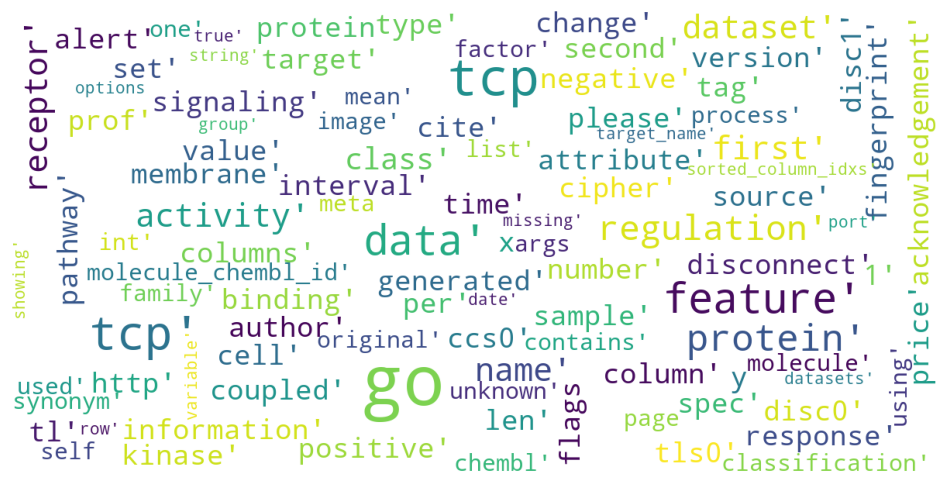

In [35]:
def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30,
        scale=3,
        collocations=False,
        random_state=1)

    wordcloud = wordcloud.generate(str(data))
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()


show_wordcloud(corpus)

## Named Entity Recognition (NER) with spaCy

Analyzing named entities in dataset descriptions to identify common entities like organizations, locations, dates, etc.

In [36]:
# Get the EntityRecognizer component from the pipeline
ner = nlp.get_pipe("ner")

# List the available entity types
entity_labels = ner.labels

print(entity_labels)

# Description for each entity type
for entity in entity_labels:
    print(f"{entity}: {spacy.explain(entity)}")

('CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART')
CARDINAL: Numerals that do not fall under another type
DATE: Absolute or relative dates or periods
EVENT: Named hurricanes, battles, wars, sports events, etc.
FAC: Buildings, airports, highways, bridges, etc.
GPE: Countries, cities, states
LANGUAGE: Any named language
LAW: Named documents made into laws.
LOC: Non-GPE locations, mountain ranges, bodies of water
MONEY: Monetary values, including unit
NORP: Nationalities or religious or political groups
ORDINAL: "first", "second", etc.
ORG: Companies, agencies, institutions, etc.
PERCENT: Percentage, including "%"
PERSON: People, including fictional
PRODUCT: Objects, vehicles, foods, etc. (not services)
QUANTITY: Measurements, as of weight or distance
TIME: Times smaller than a day
WORK_OF_ART: Titles of books, songs, etc.


### Visualization of Named Entities

Visualizing named entities in a sample dataset description.


In [37]:
# Example visualization of entities in the description of the 500th dataset
doc = nlp(df['description'][500])

# Print detected entities
print(doc.ents)

# Visualize the entities
displacy.render(doc, style="ent")

(Friedman, 80, J.H. Friedman, 1999, Friedman, Friedman, 1999, Friedman, Friedman, Friedman, 5, 5, Friedman, 5 10, first, 5, 100, 4, 10, 25, 50, 100, 5, 10, 25, 50, 80, 4, 4, 5)


/Users/ivang/miniconda3/envs/openml-tags/lib/python3.10/site-packages/thinc/shims/pytorch.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self._mixed_precision):
/Users/ivang/miniconda3/envs/openml-tags/lib/python3.10/site-packages/spacy/displacy/__init__.py:69: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display


### Named Entity Frequency Analysis

Counting the frequency of each entity type across all dataset descriptions.

In [38]:
# Perform NER on all descriptions
docs = [nlp(description) for description in tqdm(df['description'])]

# Count all named entities
entity_freq_counter = Counter([X.label_ for doc in docs for X in doc.ents])
entity_freq = entity_freq_counter.most_common()

# Plotting entity frequencies using Plotly
labels, values = zip(*entity_freq[::-1])  # Reverse for descending order in plot
entity_explanations = [spacy.explain(label) for label in labels]

# Generate the Plotly bar chart
fig = px.bar(x=values, y=labels, orientation='h', labels={'x': 'Count', 'y': 'Entity'},
             hover_data={'Entity': labels, 'Count': values, 'Description': entity_explanations})
fig.update_traces(hovertemplate='<b>Entity:</b> %{y}<br><b>Count:</b> %{x}<br><b>Description:</b> %{customdata[2]}')
fig.show()

100%|██████████| 5218/5218 [06:45<00:00, 12.87it/s]


### Exploration of Most Common Entities

Investigating the most common entities for each entity type.

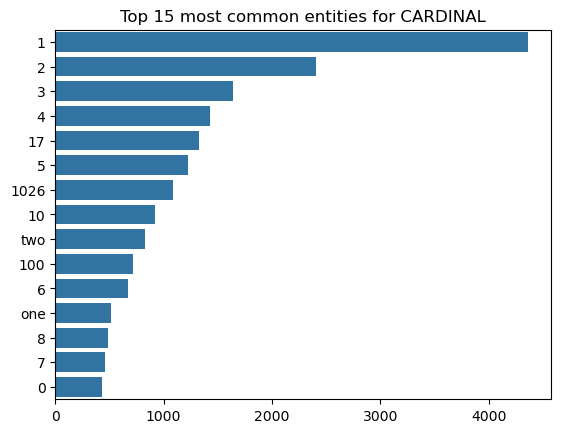

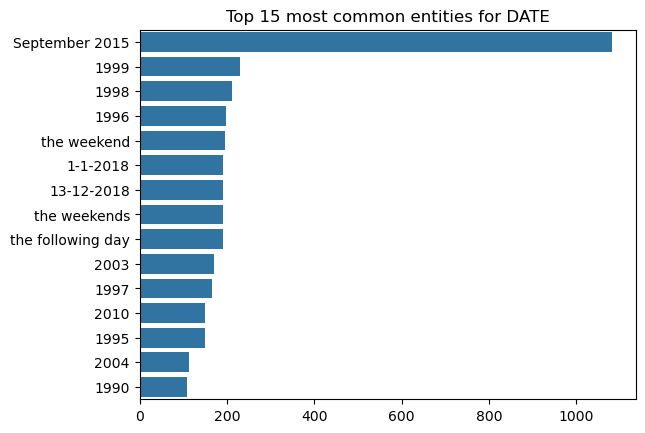

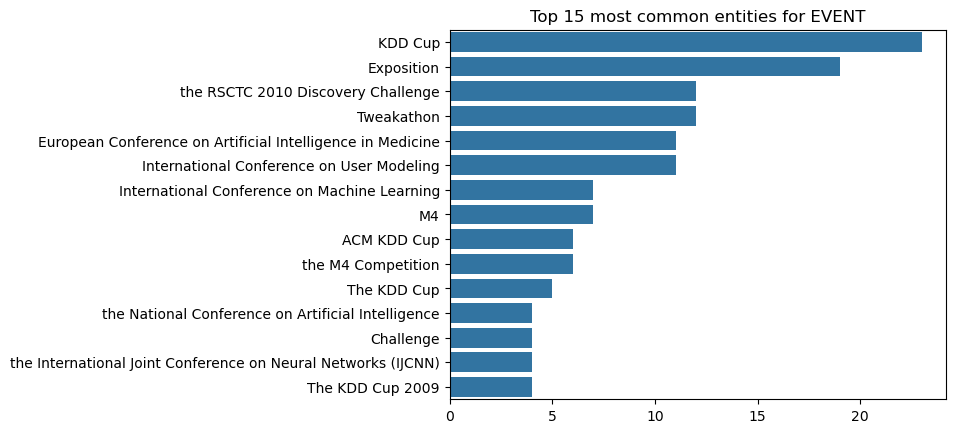

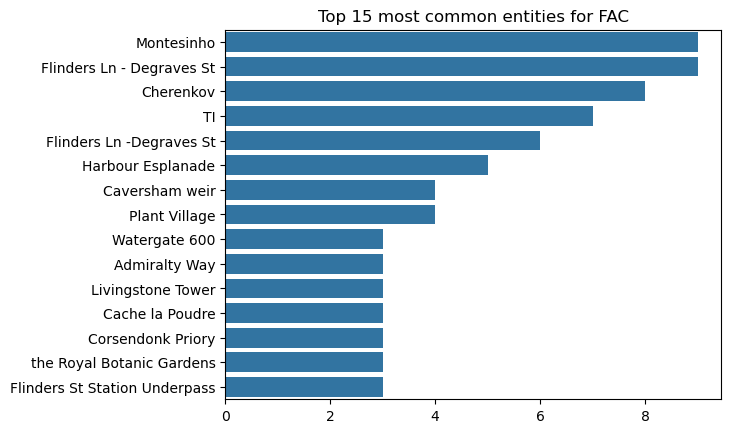

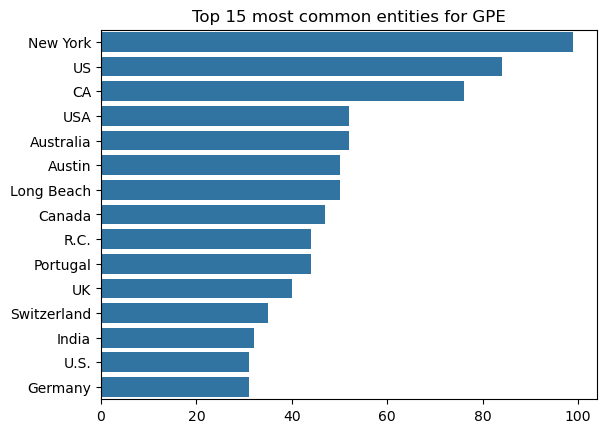

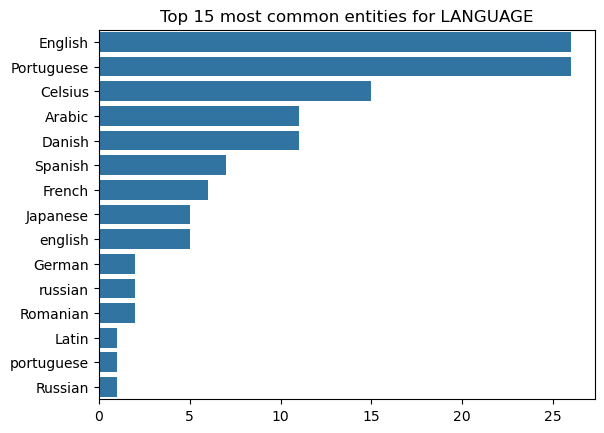

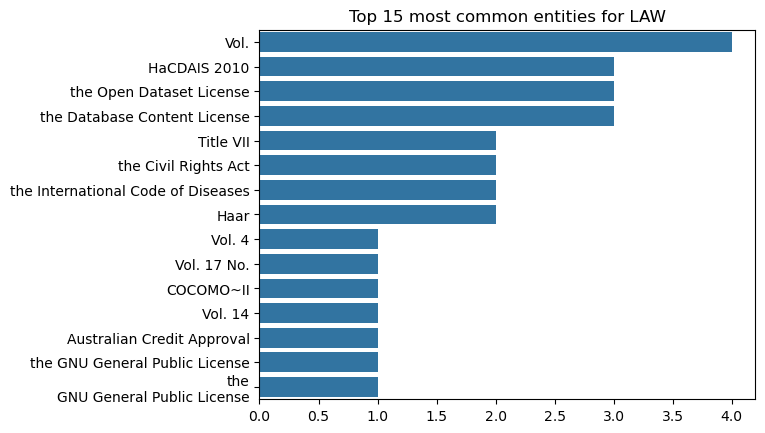

/Users/ivang/miniconda3/envs/openml-tags/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Glyph 9 (	) missing from current font.



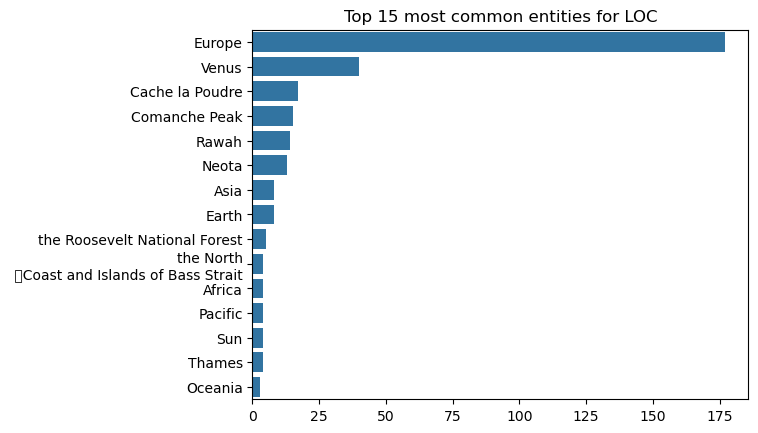

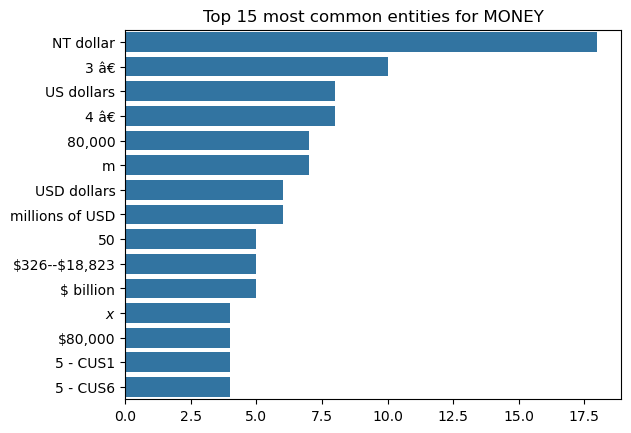

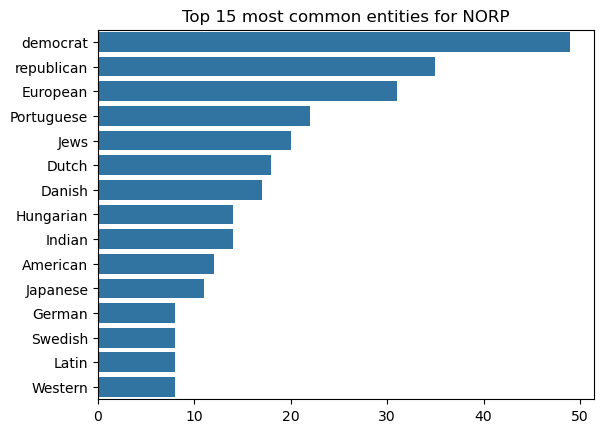

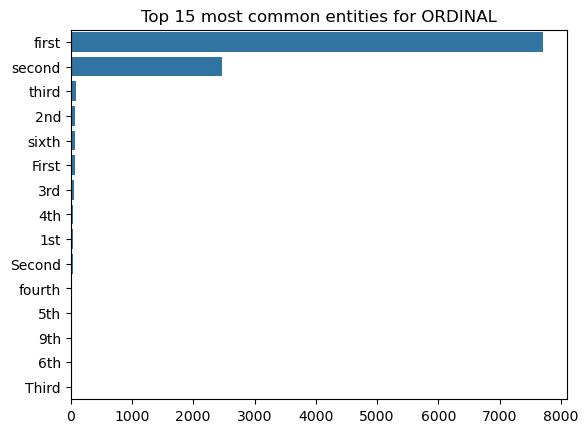

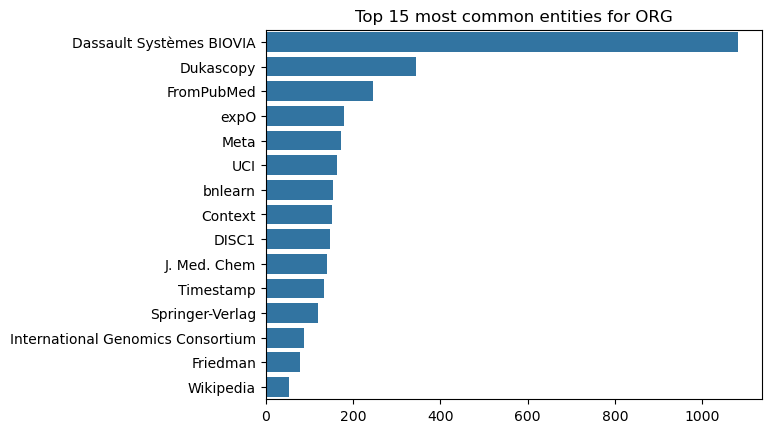

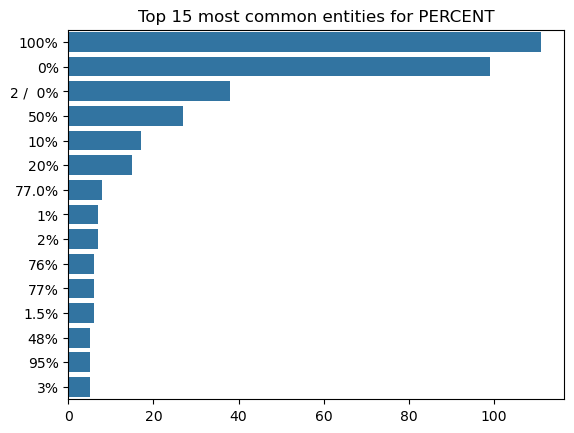

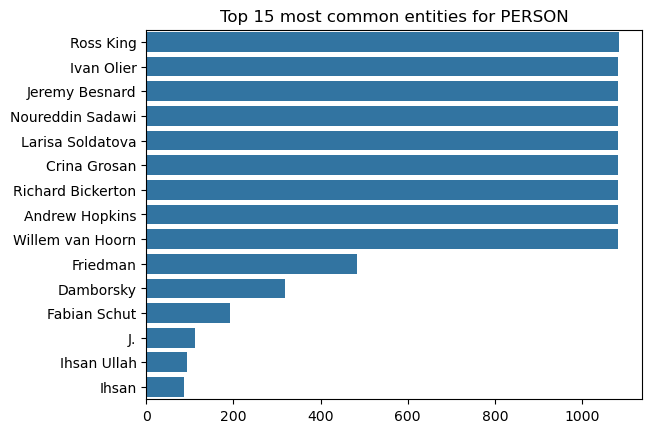

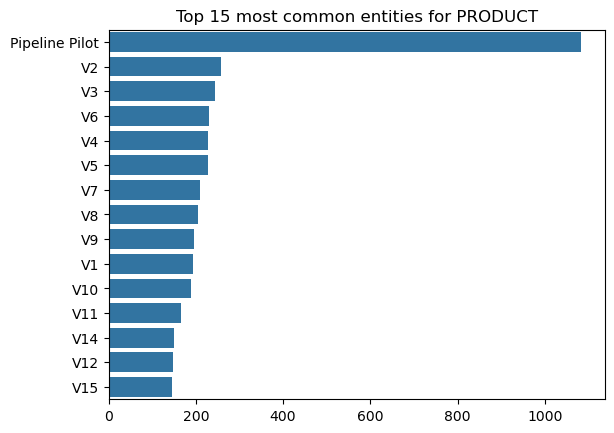

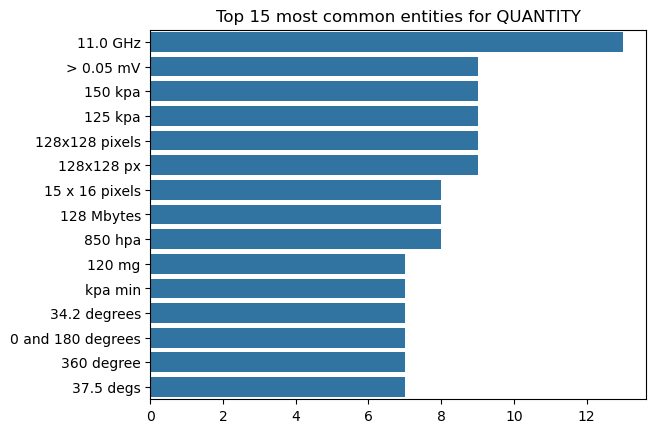

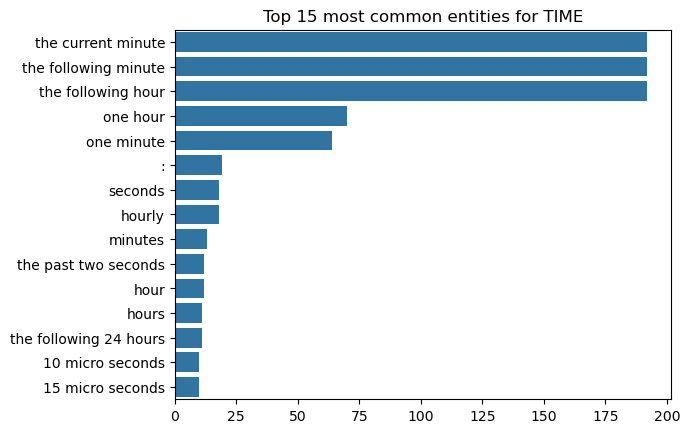

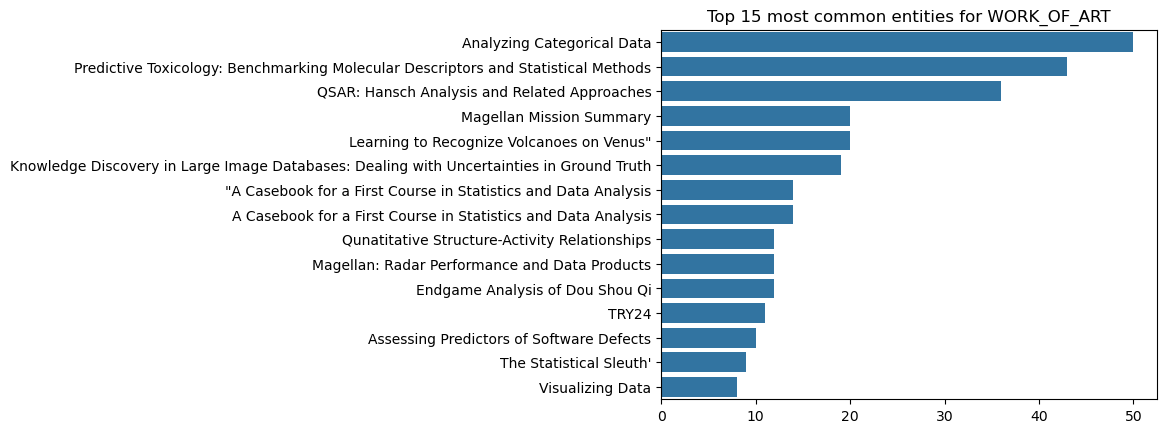

In [39]:
# Function to get the most common entities for a given label
def get_entities(label, most_common=10):
    entities = [X.text for doc in docs for X in doc.ents if X.label_ == label]
    return Counter(entities).most_common(most_common)


# Function to plot the most common entities for a given label
def plot_entities(label, k=15):
    entities = get_entities(label, k)
    entity_labels, entity_counts = zip(*entities)
    sns.barplot(x=list(entity_counts), y=list(entity_labels))
    plt.title(f'Top {k} most common entities for {label}')
    plt.show()


# Plot the most common entities for each label
for label in entity_labels:
    plot_entities(label)


## Part of Speech (POS) Tagging with spaCy

Analyzing the parts of speech in dataset descriptions to understand their grammatical composition.

In [40]:
# Example visualization of POS tags in the description of the 500th dataset 
doc = nlp(df['description'][500][:400])

options = {'distance': 75, 'compact': True, 'color': 'black', 'bg': '#f9e79f'}

# Visualize the entities
displacy.render(doc, style="dep", jupyter=True, options=options)

/Users/ivang/miniconda3/envs/openml-tags/lib/python3.10/site-packages/thinc/shims/pytorch.py:114: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.

/Users/ivang/miniconda3/envs/openml-tags/lib/python3.10/site-packages/spacy/displacy/__init__.py:69: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



In [41]:
# Example POS tagging with explanations
for token in nlp('Can you give me the can, please?'):
    print(token.text, token.pos_, token.tag_, spacy.explain(token.tag_))

# Aggregate POS tagging for all descriptions
pos_freq_counter = Counter([X.pos_ for doc in docs for X in doc])
pos_freq = pos_freq_counter.most_common()

# Plotting POS frequencies using Plotly
labels, values = zip(*pos_freq[::-1])  # Reverse for descending order in plot
pos_explanations = [spacy.explain(label) for label in labels]

# Generate the Plotly bar chart
fig = px.bar(x=values, y=labels, orientation='h', labels={'x': 'Count', 'y': 'POS'},
             hover_data={'POS': labels, 'Count': values, 'Description': pos_explanations})
fig.update_traces(hovertemplate='<b>POS:</b> %{y}<br><b>Count:</b> %{x}<br><b>Description:</b> %{customdata[2]}')
fig.show()


Can AUX MD verb, modal auxiliary
you PRON PRP pronoun, personal
give VERB VB verb, base form
me PRON PRP pronoun, personal
the DET DT determiner
can NOUN NN noun, singular or mass
, PUNCT , punctuation mark, comma
please INTJ UH interjection
? PUNCT . punctuation mark, sentence closer


## Assessing Dataset Description Complexity

Evaluating the readability of dataset descriptions using the Flesch reading ease score.


### Readability Score Interpretation

The Flesch reading ease score is interpreted as follows:
- 90-100: Very easy to read, understood by an average 11-year-old student
- 80-90: Easy to read, conversational English for consumers
- 70-80: Fairly easy to read
- 60-70: Plain English, easily understood by 13- to 15-year-old students
- 50-60: Fairly difficult to read
- 30-50: Difficult to read
- 0-30: Very difficult to read, best understood by university graduates

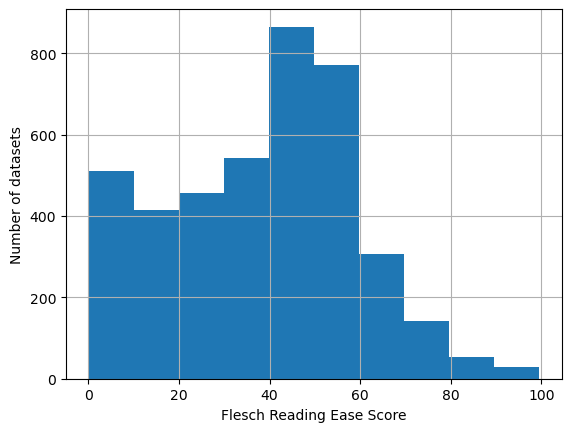

In [42]:
# Apply the Flesch reading ease test to each description, filter the ones with score below 0
stat = df['description'].apply(
    lambda x: textstat.textstat.flesch_reading_ease(x) if 0 < textstat.textstat.flesch_reading_ease(x) <= 100 else None)
stat.hist()
# put x axis label
plt.xlabel('Flesch Reading Ease Score')
# y label is number of datasets
plt.ylabel('Number of datasets')

# save as pdf
plt.savefig('../latex/thesis/figures/flesch_reading_ease.pdf')

## Exploratory Data Analysis on Tags

We perform EDA on the 'tag' feature of datasets to better understand their categorization.


### Tag Presence Analysis

Comparing the number of datasets with and without tags.

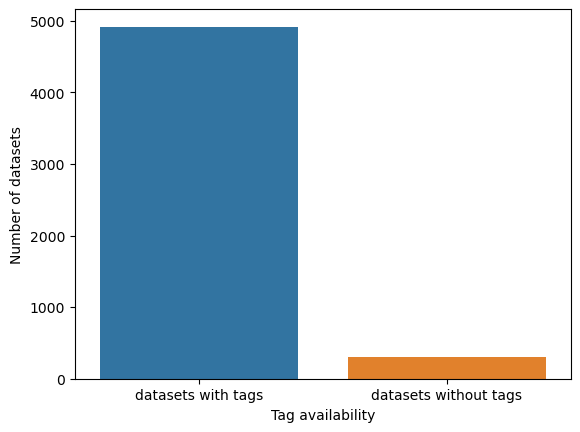

In [43]:
# Count datasets with and without tags
datasets_with_tags = df[df['tag'].notnull()]
datasets_without_tags = df[df['tag'].isnull()]

sns.barplot(x=['datasets with tags', 'datasets without tags'],
            y=[len(datasets_with_tags), len(datasets_without_tags)],
            hue=['datasets with tags', 'datasets without tags'])
#x axis label
plt.xlabel('Tag availability')
# y axis label
plt.ylabel('Number of datasets')
plt.savefig('../latex/thesis/figures/tag_availability.pdf')
plt.show()

### Tag Distribution Analysis

Analyzing the distribution of tags across datasets.

In [44]:
print(f"Average number of tags per dataset: {df['tag'].map(lambda x: len(x) if x else 0).mean()}")

Average number of tags per dataset: 4.296090456113453


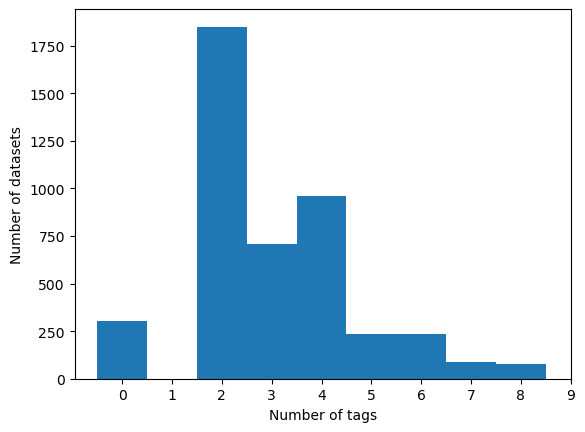

In [45]:
plt.hist(df['tag'].map(lambda x: len(x) if x else 0), bins=np.arange(0, 10) - 0.5)
plt.xlabel('Number of tags')
plt.ylabel('Number of datasets')
plt.xticks(range(10))
# save as pdf
plt.savefig('../latex/thesis/figures/number_of_tags.pdf')
plt.show()

### Most Common Tags

Identifying the most common tags across all datasets.

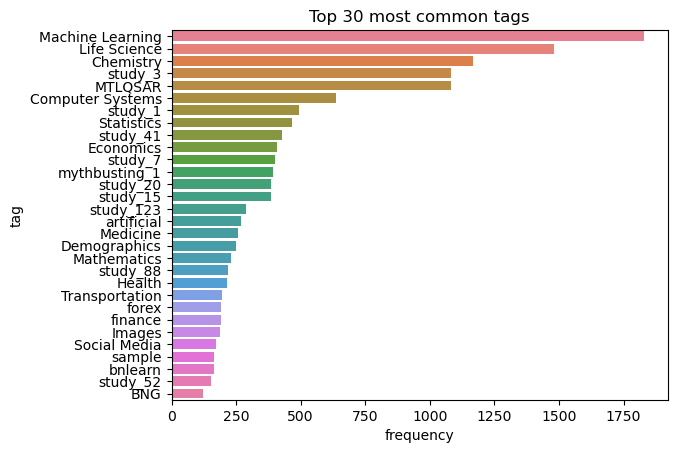

In [46]:
tags = df['tag'].dropna().map(lambda x: x if isinstance(x, list) else [x])
tags = [tag for sublist in tags for tag in sublist]
tag_freq = Counter(tags)
tag_freq = pd.DataFrame(sorted([(count, tag) for tag, count in tag_freq.items()], reverse=True))
tag_freq.columns = ['frequency', 'tag']

k = 30
sns.barplot(x=tag_freq['frequency'][:k], y=tag_freq['tag'][:k], hue=tag_freq['tag'][:k])
plt.title(f'Top {k} most common tags')
plt.show()

## Dataset Tags Analysis

Exploring the tags associated with the datasets to understand their categorization.

### POS Tagging and NER on Tags

In [47]:
df['tag']

0                                                                                                                                                    [Manufacturing, study_1, study_14, study_34, study_37, study_41, study_70, study_76, test, uci]
1       [Machine Learning, Mathematics, mythbusting_1, OpenML-CC18, OpenML100, study_1, study_123, study_14, study_144, study_15, study_20, study_218, study_34, study_37, study_41, study_50, study_52, study_7, study_70, study_98, study_99, uci]
2                                                                                                                                                            [Economics, Education, mythbusting_1, study_1, study_15, study_20, study_41, test, uci]
3                                                                                                                                                                    [Machine Learning, Medicine, sport, study_1, study_41, study_76, study_93, uci]
4                   

In [75]:
import plotly.io as pio

# Combine all tags into one list and then into a text string for processing
tags = df['tag'].dropna().tolist()
tags_combined = ' '.join([' '.join(tag_list) for tag_list in tags if isinstance(tag_list, list)])

doc_tags = nlp(tags_combined)

# POS Tagging
pos_counts = Counter([token.pos_ for token in doc_tags])

# NER
ner_counts = Counter([ent.label_ for ent in doc_tags.ents])

# Convert the counts to DataFrames for easy plotting
df_pos_counts = pd.DataFrame(pos_counts.items(), columns=['POS', 'Frequency']).sort_values(by='Frequency',
                                                                                           ascending=True)
df_ner_counts = pd.DataFrame(ner_counts.items(), columns=['Entity', 'Frequency']).sort_values(by='Frequency',
                                                                                              ascending=True)

# Plotting POS tags using Plotly
fig_pos = px.bar(df_pos_counts, x='Frequency', y='POS', orientation='h', title='Frequency of POS tags in dataset tags')
fig_pos.update_layout(xaxis_title='Frequency', yaxis_title='POS')
pio.write_image(fig_pos, '../latex/thesis/figures/pos.pdf', format='pdf')
fig_pos.show()

# Plotting NER tags using Plotly
fig_ner = px.bar(df_ner_counts, x='Frequency', y='Entity', orientation='h',
                 title='Frequency of named entities in dataset tags')
fig_ner.update_layout(xaxis_title='Frequency', yaxis_title='Entity')
# save to pdf
# fig_ner.write_image('../latex/thesis/figures/pos.pdf')
# use this way instead plotly.io.write_image(fig, 'output_file.pdf', format='pdf')
pio.write_image(fig_ner, '../latex/thesis/figures/ner.pdf', format='pdf')
fig_ner.show()

/Users/ivang/miniconda3/envs/openml-tags/lib/python3.10/site-packages/thinc/shims/pytorch.py:114: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.



## Text Similarity Analysis

We analyze the similarity between dataset descriptions using TF-IDF and cosine similarity.


### Cosine Similarity Matrix

Generating a cosine similarity matrix for the dataset descriptions.

/Users/ivang/miniconda3/envs/openml-tags/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/ivang/miniconda3/envs/openml-tags/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/ivang/miniconda3/envs/openml-tags/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


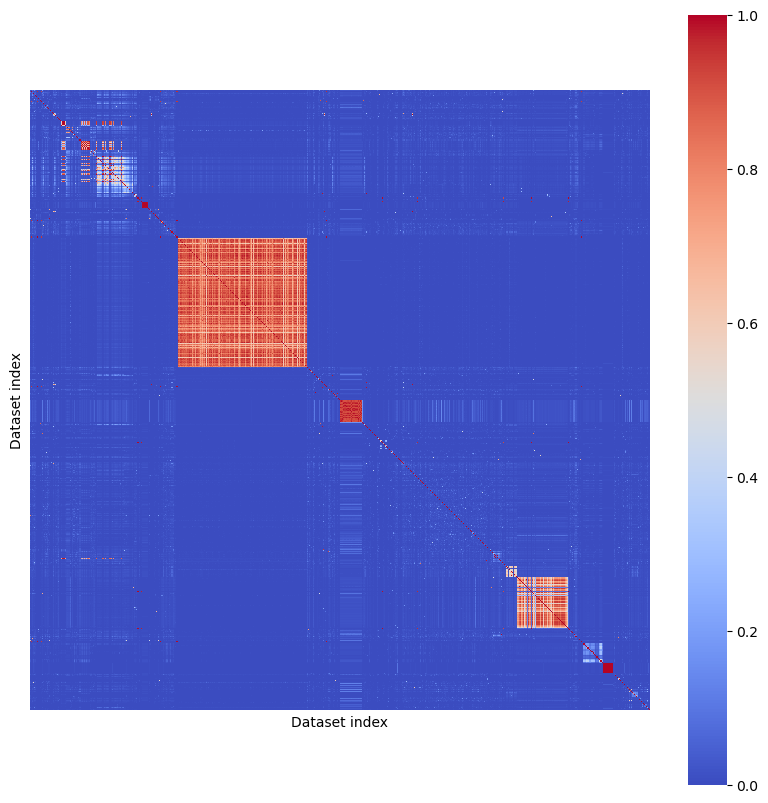

In [11]:
# Vectorize the descriptions
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['description'].map(clean))

# Calculate the cosine similarity matrix
cosine_sim = cosine_similarity(X, X)

# Plot the similarity matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cosine_sim, cmap='coolwarm', square=True, xticklabels=False, yticklabels=False)
# x label
plt.xlabel('Dataset index')
# y label
plt.ylabel('Dataset index')
# plt.savefig('../latex/thesis/figures/cosine_similarity.pdf')
# save as png cos pdf is too large
plt.savefig('../latex/thesis/figures/cosine_similarity.png')
plt.show()

### Distribution of Cosine Similarities

Examining the distribution of similarity scores between different dataset descriptions.

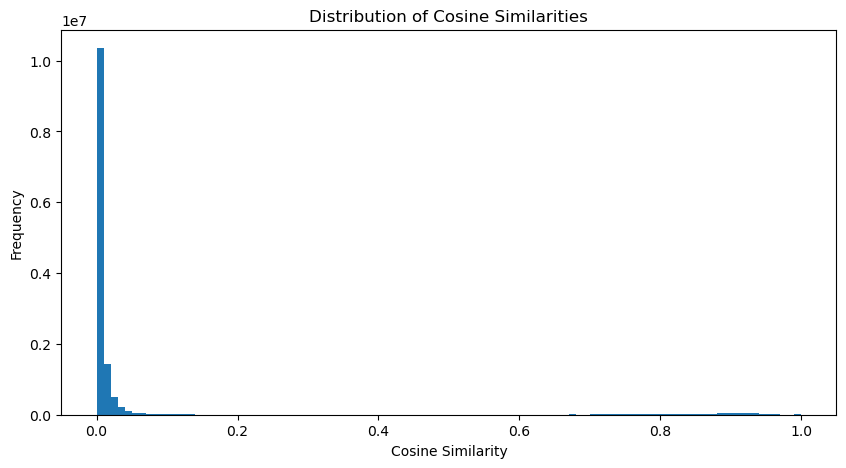

In [50]:
# Extract the upper triangle of the matrix, excluding the diagonal
upper_tri_idx = np.triu_indices_from(cosine_sim, k=1)
unique_similarities = cosine_sim[upper_tri_idx]

plt.figure(figsize=(10, 5))
plt.hist(unique_similarities, bins=100)
plt.title('Distribution of Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()

### Similar Dataset Pairs

Filtering dataset pairs with a high level of similarity (cosine similarity > 0.9).

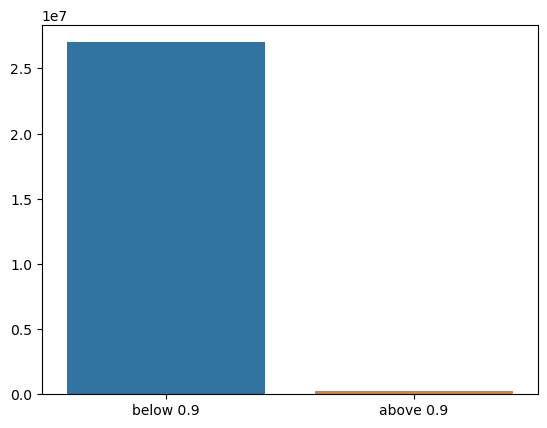

In [51]:
sns.barplot(x=['below 0.9', 'above 0.9'],
            y=[len(np.where(np.triu(cosine_sim, k=1) < 0.9)[0]), len(np.where(np.triu(cosine_sim, k=1) > 0.9)[0])],
            hue=['below 0.9', 'above 0.9'])
plt.show()

In [52]:
above_threshold_indices = np.where(np.triu(cosine_sim, k=1) > 0.9)

# Extract the dataset pairs based on the indices
similar_pairs = [(i, j, cosine_sim[i, j]) for i, j in zip(*above_threshold_indices)]

# Create a new DataFrame to store the similar dataset pairs with their similarity score
similar_df = pd.DataFrame(similar_pairs, columns=['Dataset_ID_1', 'Dataset_ID_2', 'Similarity'])

# Add dataset names, descriptions, openml_url, and version to the DataFrame for easier interpretation
similar_df['Dataset_Name_1'] = similar_df['Dataset_ID_1'].apply(lambda x: df.iloc[x]['name'])
similar_df['Dataset_Description_1'] = similar_df['Dataset_ID_1'].apply(lambda x: df.iloc[x]['description'])
similar_df['OpenML_URL_1'] = similar_df['Dataset_ID_1'].apply(lambda x: df.iloc[x]['openml_url'])
similar_df['Version_1'] = similar_df['Dataset_ID_1'].apply(lambda x: df.iloc[x]['version'])

similar_df['Dataset_Name_2'] = similar_df['Dataset_ID_2'].apply(lambda x: df.iloc[x]['name'])
similar_df['Dataset_Description_2'] = similar_df['Dataset_ID_2'].apply(lambda x: df.iloc[x]['description'])
similar_df['OpenML_URL_2'] = similar_df['Dataset_ID_2'].apply(lambda x: df.iloc[x]['openml_url'])
similar_df['Version_2'] = similar_df['Dataset_ID_2'].apply(lambda x: df.iloc[x]['version'])

similar_df

Dataset_ID_1  Dataset_ID_2  Similarity Dataset_Name_1  \
0                  7           128    0.915847          autos   
1                  7           135    0.915925          autos   
2                 10            12    0.994702  mfeat-factors   
3                 10            14    0.983919  mfeat-factors   
4                 10            16    0.997636  mfeat-factors   
...              ...           ...         ...            ...   
224520          5201          5203    0.908295      Car-Parts   
224521          5201          5204    0.901939      Car-Parts   
224522          5203          5204    0.988275        FRED-MD   
224523          5209          5210    0.921301      seclogs_1   
224524          5215          5216    0.948006    Solar-Power   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [53]:
# Show an example of dataset pairs with high similarity 
similar_df[similar_df['Dataset_ID_1'] == 1287]

Dataset_ID_1  Dataset_ID_2  Similarity   Dataset_Name_1  \
23610          1287          1293    0.923235  QSAR-TID-100835   
23611          1287          1298    0.902305  QSAR-TID-100835   
23612          1287          1302    0.917864  QSAR-TID-100835   
23613          1287          1304    0.932921  QSAR-TID-100835   
23614          1287          1314    0.943861  QSAR-TID-100835   
...             ...           ...         ...              ...   
23824          1287          2315    0.900993  QSAR-TID-100835   
23825          1287          2319    0.919877  QSAR-TID-100835   
23826          1287          2322    0.906433  QSAR-TID-100835   
23827          1287          2326    0.922075  QSAR-TID-100835   
23828          1287          2330    0.942210  QSAR-TID-100835   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

## Comparing Versions of Datasets

Investigating how dataset descriptions vary across different versions of the same dataset.

### Analysis of Similarity Between Different Dataset Versions

In [54]:
# Filter the similar_df for entries with the same name and different version (as before)
same_name_different_version = similar_df[
    (similar_df['Dataset_Name_1'] == similar_df['Dataset_Name_2']) &
    (similar_df['Version_1'] != similar_df['Version_2'])
    ]

# Filter the similar_df for entries that are not the same dataset (the complement)
not_same_dataset = similar_df[
    (similar_df['Dataset_Name_1'] != similar_df['Dataset_Name_2'])
]

In [55]:
same_name_different_version

Dataset_ID_1  Dataset_ID_2  Similarity           Dataset_Name_1  \
19                10           818    0.963102            mfeat-factors   
83                12           811    0.935590            mfeat-fourier   
143               14           860    0.912240           mfeat-karhunen   
201               16           862    0.961213              mfeat-pixel   
232               16          2476    0.973214              mfeat-pixel   
...              ...           ...         ...                      ...   
224494          5056          5060    1.000000  flycraft-demonstrations   
224495          5057          5059    1.000000  flycraft-demonstrations   
224496          5057          5061    1.000000  flycraft-demonstrations   
224497          5058          5060    1.000000  flycraft-demonstrations   
224498          5059          5061    1.000000  flycraft-demonstrations   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [56]:
not_same_dataset

Dataset_ID_1  Dataset_ID_2  Similarity Dataset_Name_1  \
0                  7           128    0.915847          autos   
1                  7           135    0.915925          autos   
2                 10            12    0.994702  mfeat-factors   
3                 10            14    0.983919  mfeat-factors   
4                 10            16    0.997636  mfeat-factors   
...              ...           ...         ...            ...   
224520          5201          5203    0.908295      Car-Parts   
224521          5201          5204    0.901939      Car-Parts   
224522          5203          5204    0.988275        FRED-MD   
224523          5209          5210    0.921301      seclogs_1   
224524          5215          5216    0.948006    Solar-Power   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

### Visualizing Similarity Distribution for Different Versions

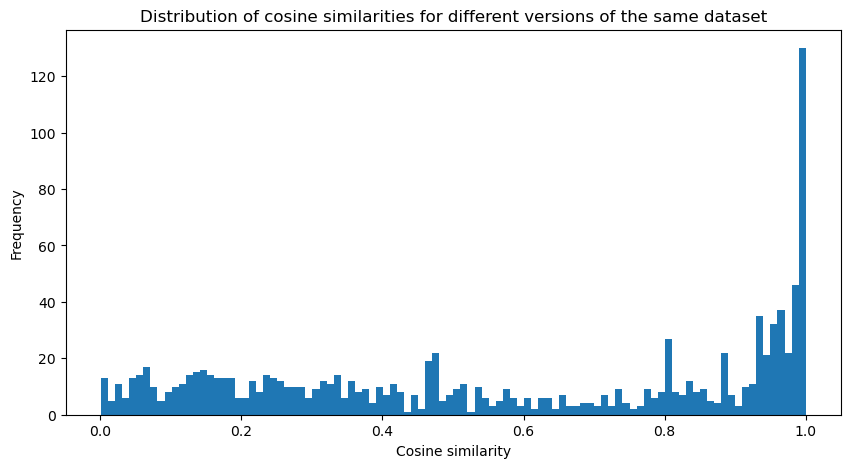

In [57]:
name_to_indices = defaultdict(list)
for i, row in df.iterrows():
    name_to_indices[row['name']].append(df.index.get_loc(i))

version_similarity = []

for name, indices in name_to_indices.items():
    # Only consider names with more than one version
    if len(indices) > 1:
        for i in range(len(indices)):
            for j in range(i + 1, len(indices)):
                idx1, idx2 = indices[i], indices[j]
                similarity = cosine_sim[idx1, idx2]
                version_similarity.append({
                    'Dataset_Name': name,
                    'Version_1': df.iloc[idx1]['version'],
                    'OpenML_URL_1': df.iloc[idx1]['openml_url'],
                    'Version_2': df.iloc[idx2]['version'],
                    'OpenML_URL_2': df.iloc[idx2]['openml_url'],
                    'Similarity': similarity
                })

version_similarity_df = pd.DataFrame(version_similarity)

version_similarity_sorted = version_similarity_df.sort_values(by=['Dataset_Name', 'Similarity'],
                                                              ascending=[True, False])
plt.figure(figsize=(10, 5))
plt.hist(version_similarity_sorted['Similarity'], bins=100)

plt.title('Distribution of cosine similarities for different versions of the same dataset')
plt.xlabel('Cosine similarity')
plt.ylabel('Frequency')
# # x axis label
# plt.xlabel('Description Type')
# # y axis label
# plt.ylabel('Average Length')
# plt.savefig('../latex/thesis/figures/description_vs_augmented_description.pdf')
# plt.show()
# do similar like above
plt.savefig('../latex/thesis/figures/cosine_similarity_dataset_versions.pdf')
plt.show()

### Most Similar Dataset Versions

Identifying the most similar versions of datasets based on cosine similarity.

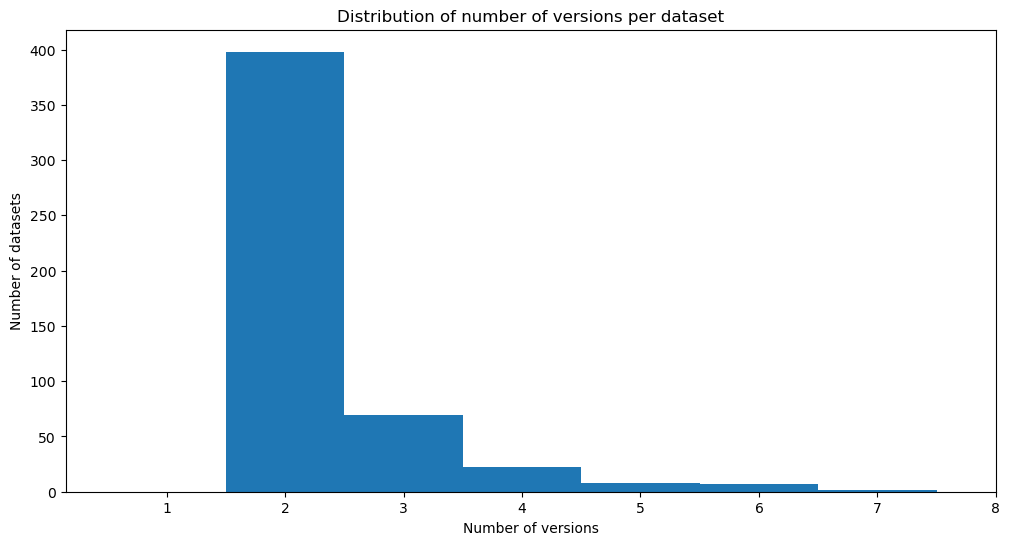

In [58]:
# Group by the 'name' column and count the number of versions for each dataset
version_counts = df.groupby('name').size()

# We're interested in datasets that have more than one version
multiple_versions = version_counts[version_counts > 1]

num_bins = min(multiple_versions.nunique(), 50)

plt.figure(figsize=(12, 6))
plt.hist(multiple_versions, bins=np.arange(1, num_bins + 1) - 0.5)

plt.title('Distribution of number of versions per dataset')
plt.xlabel('Number of versions')
plt.ylabel('Number of datasets')

plt.xticks(range(1, num_bins + 1))

plt.savefig('../latex/thesis/figures/number_of_versions.pdf')
plt.show()

## Dataset Features

Analyzing the features of the datasets such as the number of features and their types.

### POS Tagging and NER on Features
This doesn't make sense to include, as the number of features is very large, and they are not connected in any meaningful sense in sentences.

In [59]:
features = df['_features']

# Wrap the outer loop with tqdm for a progress bar
docs = [nlp(feature.name) for feature_list in tqdm(features, desc='Processing features') for feature in
        feature_list.values()]

# Count all named entities
overall_pos_counts = Counter([X.pos_ for doc in docs for X in doc])
overall_ner_counts = Counter([X.label_ for doc in docs for X in doc.ents])

# Convert the overall counts to DataFrames for easy plotting
df_pos_counts = pd.DataFrame(overall_pos_counts.items(), columns=['POS', 'Frequency']).sort_values(by='Frequency',
                                                                                                   ascending=True)
df_ner_counts = pd.DataFrame(overall_ner_counts.items(), columns=['Entity', 'Frequency']).sort_values(by='Frequency',
                                                                                                      ascending=True)

# Plotting POS tags using Plotly
fig_pos = px.bar(df_pos_counts, x='Frequency', y='POS', orientation='h',
                 title='Frequency of POS tags in dataset features')
fig_pos.update_layout(xaxis_title='Frequency', yaxis_title='POS')
fig_pos.show()

# Plotting NER using Plotly
fig_ner = px.bar(df_ner_counts, x='Frequency', y='Entity', orientation='h',
                 title='Frequency of named entities in dataset features')
fig_ner.update_layout(xaxis_title='Frequency', yaxis_title='Entity')
fig_ner.show()

Processing features:   0%|          | 0/5218 [00:00<?, ?it/s]/Users/ivang/miniconda3/envs/openml-tags/lib/python3.10/site-packages/thinc/shims/pytorch.py:114: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.

Processing features: 100%|██████████| 5218/5218 [42:23<00:00,  2.05it/s]  


### Distribution of Number of Features

In [60]:
df._features.map(lambda feature_list: [feature.name for feature in feature_list.values()])

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

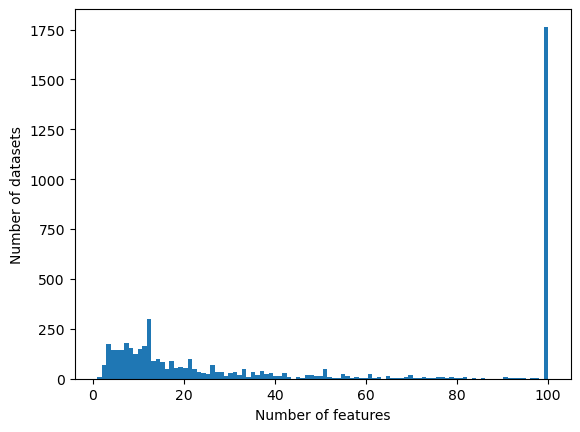

In [61]:
num_features = df._features.map(len)
plt.hist(num_features[num_features < 1000], bins=100, color='C0')
plt.xlabel('Number of features')
plt.ylabel('Number of datasets')
# save to pdf
plt.savefig('../latex/thesis/figures/number_of_features.pdf')
plt.show()

### Distribution of Number of Features with feature count > 1000 and > 2000

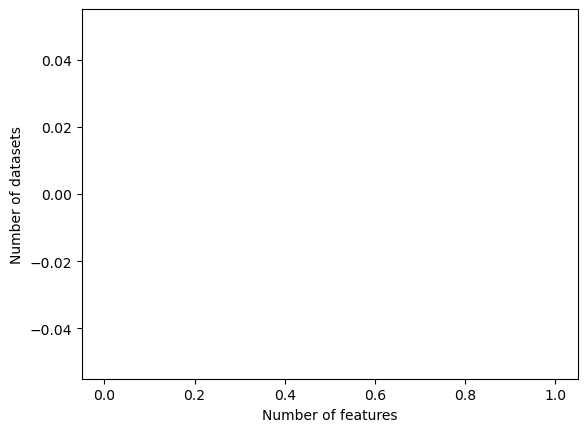

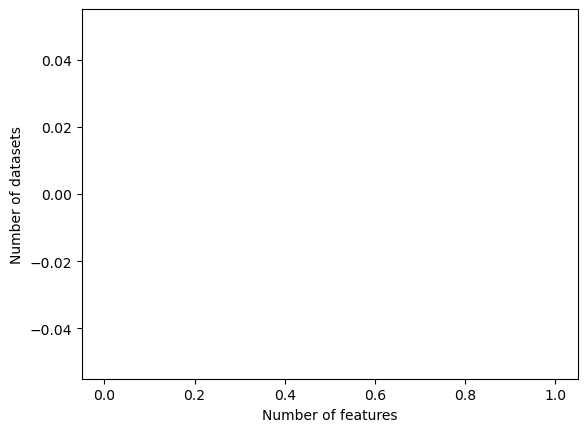

In [62]:
plt.hist(num_features[(num_features > 1000) & (num_features < 2000)], bins=10, color='C0')
plt.xlabel('Number of features')
plt.ylabel('Number of datasets')
plt.show()

plt.hist(num_features[(num_features > 2000)], bins=10, color='C0')
plt.xlabel('Number of features')
plt.ylabel('Number of datasets')
plt.show()

## URL Analysis in Dataset Descriptions

Identifying and analyzing the presence of URLs in the dataset descriptions.

### Datasets with URLs

In [63]:
# Function to check if a description contains a URL
def contains_url(description):
    extractor = URLExtract()
    urls = extractor.find_urls(description)
    return bool(urls)


datasets_with_urls = df[df['description'].apply(contains_url)]
datasets_with_urls

ignore_attribute  dataset_id         name  version cache_format format  \
0                None           2       anneal        1       pickle   ARFF   
1                None           3     kr-vs-kp        1       pickle   ARFF   
2                None           4        labor        1       pickle   ARFF   
3                None           5   arrhythmia        1       pickle   ARFF   
4                None           6       letter        1       pickle   ARFF   
...               ...         ...          ...      ...          ...    ...   
5632             None       46162         lung        2       pickle   arff   
5644             None       46174        Flare        1       pickle   arff   
5660             None       46190    Rideshare        1       pickle   arff   
5675             None       46205  Solar-Power        1       pickle   arff   
5676             None       46206   Wind-Power        1       pickle   arff   

                                                                                                             creator  \
0                                                                                     [David Sterling, Wray Buntine]   
1                                                                                                       Alen Shapiro   
2                                                                      Collective Bargaining Review of Labour Canada   
3                                                                [H. Altay Guvenir, Burak Acar, Haldun Muderrisoglu]   
4                                                                                                     David J. Slate   
...                                                                                                              ...   
5632                                                                                                            None   
5644                                                                                                            None   
5660                       Godahewa, Rakshitha; Bergmeir, Christoph; Webb, Geoff; Hyndman, Rob; Montero-Manso, Pablo   
5675  Godahewa, Rakshitha; Bergmeir, Christoph;  Webb, Geoff; Abolghasemi, Mahdi; Hyndman, Rob; Montero-Manso, Pablo   
5676  Godahewa, Rakshitha; Bergmeir, Christoph;  Webb, Geoff; Abolghasemi, Mahdi; Hyndman, Rob; Montero-Manso, Pablo   

                          contributor collection_date          upload_date  \
0     David Sterling and Wray Buntine            1990  2014-04-06T23:19:24   
1                           Rob Holte      1989-08-01  2014-04-06T23:19:28   
2                         Stan Matwin      1988-11-01  2014-04-06T23:19:30   
3                                None      1998-01-01  2014-04-06T23:19:36   
4                                None      1991-01-01  2014-04-06T23:19:41   
...                               ...             ...                  ...   
5632                             None            None  2024-06-07T16:35:49   
5644                             None            None  2024-06-10T20:01:27   
5660                    Bruno Belucci   July 22, 2021  2024-06-12T16:48:09   
5675                             None            2020  2024-06-21T22:53:58   
5676                             None            2020  2024-06-21T22:59:56   

      ... _qualities _no_qualities_found data_pickle_file data_feather_file  \
0     ...       None               False             None              None   
1     ...       None               False             None              None   
2     ...       None               False             None              None   
3     ...       None               False             None              None   
4     ...       None               False             None              None   
...   ...        ...                 ...              ...               ...   
5632  ...       None               False             None              None   
5644  ...       None               False      

### Visualization of Datasets with URLs vs Datasets without URLs 

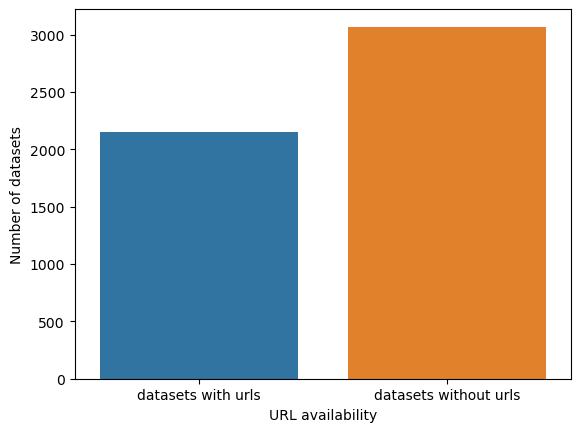

In [64]:
sns.barplot(x=['datasets with urls', 'datasets without urls'],
            y=[len(datasets_with_urls), len(df) - len(datasets_with_urls)],
            hue=['datasets with urls', 'datasets without urls'])
# x label
plt.xlabel('URL availability')
# y label
plt.ylabel('Number of datasets')
plt.savefig('../latex/thesis/figures/url_availability.pdf')

### Number of URLs in Dataset Descriptions

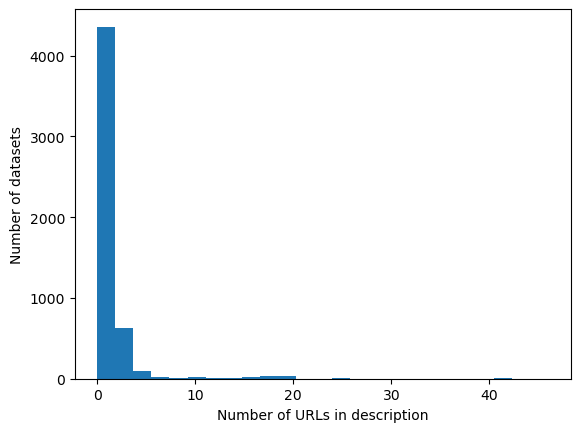

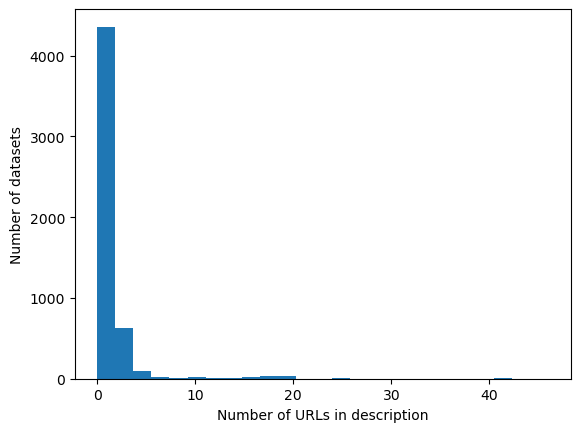

In [65]:
# Plot the number of URLs in dataset descriptions for all datasets
plt.hist(df['description'].apply(lambda x: len(URLExtract().find_urls(x))), bins=25, color='C0')
plt.xlabel('Number of URLs in description')
plt.ylabel('Number of datasets')
plt.show()

plt.hist(
    df['description'].apply(lambda x: len(URLExtract().find_urls(x)) if len(URLExtract().find_urls(x)) < 100 else 100),
    bins=25, color='C0')
plt.xlabel('Number of URLs in description')
plt.ylabel('Number of datasets')
plt.show()

In [66]:
# For each dataset, extract their urls, and put it in a column "description_urls"
def extract_urls(description):
    # Find all URLs in the description
    extractor = URLExtract()
    urls = extractor.find_urls(description)
    return urls


datasets_with_urls['description_urls'] = datasets_with_urls['description'].apply(extract_urls)
datasets_with_urls

/var/folders/cl/69z7wmcn5xx7cb7wc_xvd8fw0000gn/T/ipykernel_52971/3812673844.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ignore_attribute  dataset_id         name  version cache_format format  \
0                None           2       anneal        1       pickle   ARFF   
1                None           3     kr-vs-kp        1       pickle   ARFF   
2                None           4        labor        1       pickle   ARFF   
3                None           5   arrhythmia        1       pickle   ARFF   
4                None           6       letter        1       pickle   ARFF   
...               ...         ...          ...      ...          ...    ...   
5632             None       46162         lung        2       pickle   arff   
5644             None       46174        Flare        1       pickle   arff   
5660             None       46190    Rideshare        1       pickle   arff   
5675             None       46205  Solar-Power        1       pickle   arff   
5676             None       46206   Wind-Power        1       pickle   arff   

                                                                                                             creator  \
0                                                                                     [David Sterling, Wray Buntine]   
1                                                                                                       Alen Shapiro   
2                                                                      Collective Bargaining Review of Labour Canada   
3                                                                [H. Altay Guvenir, Burak Acar, Haldun Muderrisoglu]   
4                                                                                                     David J. Slate   
...                                                                                                              ...   
5632                                                                                                            None   
5644                                                                                                            None   
5660                       Godahewa, Rakshitha; Bergmeir, Christoph; Webb, Geoff; Hyndman, Rob; Montero-Manso, Pablo   
5675  Godahewa, Rakshitha; Bergmeir, Christoph;  Webb, Geoff; Abolghasemi, Mahdi; Hyndman, Rob; Montero-Manso, Pablo   
5676  Godahewa, Rakshitha; Bergmeir, Christoph;  Webb, Geoff; Abolghasemi, Mahdi; Hyndman, Rob; Montero-Manso, Pablo   

                          contributor collection_date          upload_date  \
0     David Sterling and Wray Buntine            1990  2014-04-06T23:19:24   
1                           Rob Holte      1989-08-01  2014-04-06T23:19:28   
2                         Stan Matwin      1988-11-01  2014-04-06T23:19:30   
3                                None      1998-01-01  2014-04-06T23:19:36   
4                                None      1991-01-01  2014-04-06T23:19:41   
...                               ...             ...                  ...   
5632                             None            None  2024-06-07T16:35:49   
5644                             None            None  2024-06-10T20:01:27   
5660                    Bruno Belucci   July 22, 2021  2024-06-12T16:48:09   
5675                             None            2020  2024-06-21T22:53:58   
5676                             None            2020  2024-06-21T22:59:56   

      ... _no_qualities_found data_pickle_file data_feather_file  \
0     ...               False             None              None   
1     ...               False             None              None   
2     ...               False             None              None   
3     ...               False             None              None   
4     ...               False             None              None   
...   ...                 ...              ...               ...   
5632  ...               False             None              None   
5644  ...               False             None              None   
5660  ...               False             None              None  

In [67]:
def extract_domain(description):
    # Find all URLs in the description
    extractor = URLExtract()
    urls = extractor.find_urls(description)
    domains = []
    for url in urls:
        # Prepend a scheme if missing
        if not url.startswith(('http://', 'https://')):
            url = 'http://' + url
        try:
            domain = urlparse(url).netloc
            if domain:
                domains.append(domain)
            else:
                print(f"Error: No domain found in URL: {url}")
        except ValueError as e:
            # If an invalid URL is found, log an error message
            print(f"ValueError: {str(e)} in URL: {url}")
    return domains


domains = datasets_with_urls['description'].apply(extract_domain)
domains

0       [archive.ics.uci.edu, archive.ics.uci.edu]
1       [archive.ics.uci.edu, archive.ics.uci.edu]
2                            [archive.ics.uci.edu]
3       [archive.ics.uci.edu, archive.ics.uci.edu]
4                            [archive.ics.uci.edu]
                           ...                    
5632                                    [meal.cal]
5644                                [sci2s.ugr.es]
5660                  [www.kaggle.com, zenodo.org]
5675              [aemo.com.au, www.nemweb.com.au]
5676              [aemo.com.au, www.nemweb.com.au]
Name: description, Length: 2150, dtype: object

### Distribution of Domains

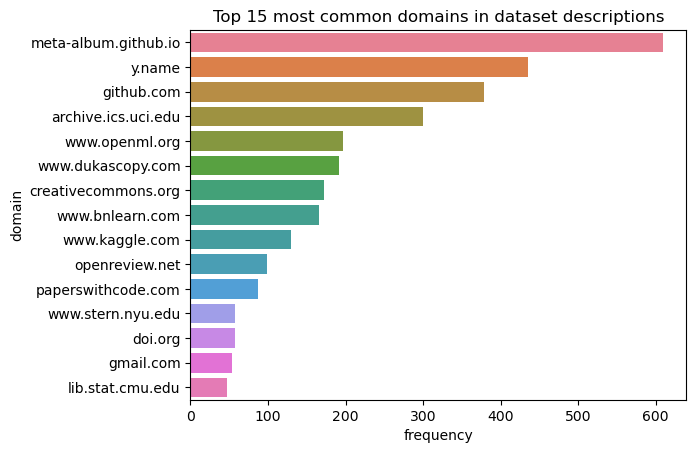

In [68]:
sublists = [domain for sublist in domains for domain in sublist]
domain_freq = Counter(sublists)
domain_freq = pd.DataFrame(sorted([(count, domain) for domain, count in domain_freq.items()], reverse=True))
domain_freq.columns = ['frequency', 'domain']

k = 15
sns.barplot(x=domain_freq['frequency'][:k], y=domain_freq['domain'][:k], hue=domain_freq['domain'][:k])
plt.title(f'Top {k} most common domains in dataset descriptions')
plt.show()

In [69]:
def extract_urls(description):
    # Find all URLs in the description
    extractor = URLExtract()
    urls = extractor.find_urls(description)
    return urls


urls = datasets_with_urls['description'].apply(extract_urls)
urls_df = pd.DataFrame(urls)
urls_df

description
0                          [https://archive.ics.uci.edu/ml/datasets/Annealing, https://archive.ics.uci.edu/ml/citation_policy.html]
1     [https://archive.ics.uci.edu/ml/datasets/Chess+(King-Rook+vs.+King-Pawn, https://archive.ics.uci.edu/ml/citation_policy.html]
2                                                                             [https://archive.ics.uci.edu/ml/citation_policy.html]
3                         [https://archive.ics.uci.edu/ml/datasets/arrhythmia, https://archive.ics.uci.edu/ml/citation_policy.html]
4                                                                      [https://archive.ics.uci.edu/ml/datasets/Letter+Recognition]
...                                                                                                                             ...
5632                                                                                                                     [meal.cal]
5644                                                                              [https://sci2s.ugr.es/keel/category.php?cat=clas]
5660                    [https://www.kaggle.com/datasets/ravi72munde/uber-lyft-cab-prices/data, https://zenodo.org/records/5122114]
5675                                                                            [https://aemo.com.au/, http://www.nemweb.com.au/).]
5676                                                                            [https://aemo.com.au/, http://www.nemweb.com.au/).]

[2150 rows x 1 columns]

In [70]:
urls_df.head(50)

description
0                                                                                                                                                                               [https://archive.ics.uci.edu/ml/datasets/Annealing, https://archive.ics.uci.edu/ml/citation_policy.html]
1                                                                                                                                                          [https://archive.ics.uci.edu/ml/datasets/Chess+(King-Rook+vs.+King-Pawn, https://archive.ics.uci.edu/ml/citation_policy.html]
2                                                                                                                                                                                                                                  [https://archive.ics.uci.edu/ml/citation_policy.html]
3                                                                                                                                                                              [https://archive.ics.uci.edu/ml/datasets/arrhythmia, https://archive.ics.uci.edu/ml/citation_policy.html]
4                                                                                                                                                                                                                           [https://archive.ics.uci.edu/ml/datasets/Letter+Recognition]
5                                                                                                                                                                                                                      [https://archive.ics.uci.edu/ml/datasets/Audiology+(Standardized]
6                                                                                                                                                                                                                              [https://archive.ics.uci.edu/ml/datasets/Liver+Disorders]
7                                                                                                                                                                                                                                   [https://archive.ics.uci.edu/ml/datasets/Automobile]
9                                                                                                                                                                            [http://archive.ics.uci.edu/ml/datasets/balance+scale, https://archive.ics.uci.edu/ml/citation_policy.html]
10                                                                                                                                                                      [https://archive.ics.uci.edu/ml/datasets/Multiple+Features, https://archive.ics.uci.edu/ml/citation_policy.html]
12                                                                                                                                                                      [https://archive.ics.uci.edu/ml/datasets/Multiple+Features, https://archive.ics.uci.edu/ml/citation_policy.html]
13   [https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original, http://pages.cs.wisc.edu/~olvi/uwmp/cancer.html, https://archive.ics.uci.edu/ml/citation_policy.html, ftp://ftp.cs.wisc.edu/math-prog/cpo-dataset/machine-learn/cancer/, https://www.openml.org/d/1510]
14                                                                                                                                                                      [https://archive.ics.uci.edu/ml/datasets/Multiple+Features, https://archive.ics.uci.edu/ml/citation_policy.html]
15                                                                                                                                                                      [https://archive.ics.uci.edu/ml/datasets/Multiple+Features, https://archive.ics.uci.edu/ml/citation_policy.html]
16                                                    

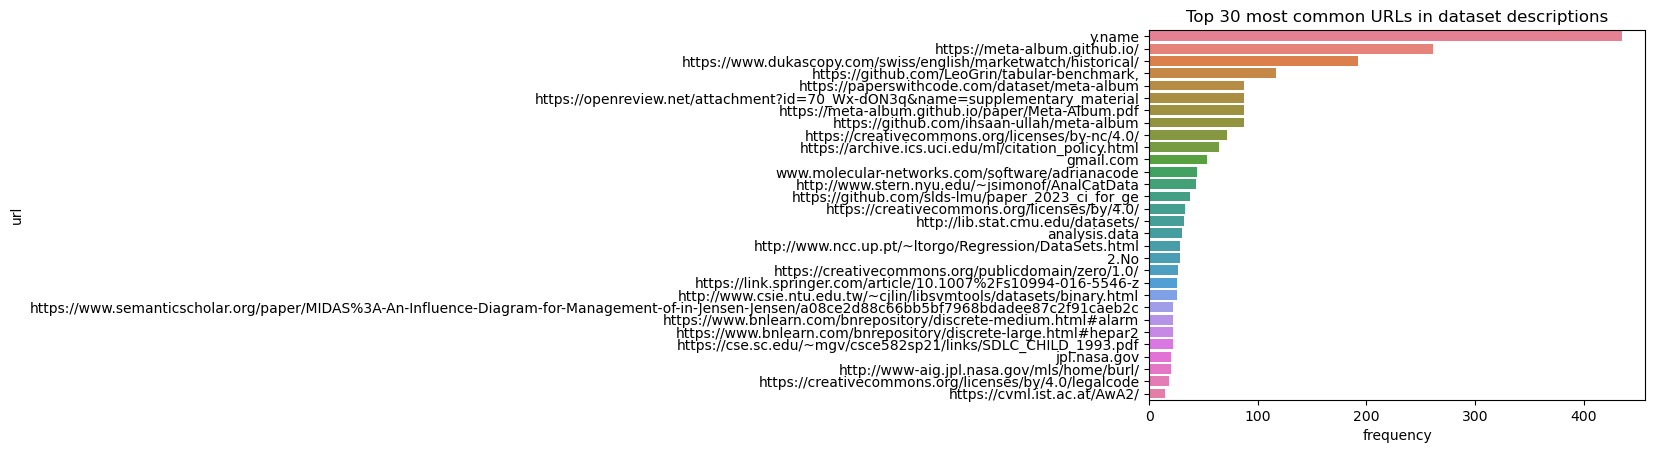

In [71]:
sublists = [url for sublist in urls for url in sublist]
url_freq = Counter(sublists)
url_freq = pd.DataFrame(sorted([(count, url) for url, count in url_freq.items()], reverse=True))
url_freq.columns = ['frequency', 'url']

k = 30
sns.barplot(x=url_freq['frequency'][:k], y=url_freq['url'][:k], hue=url_freq['url'][:k])
plt.title(f'Top {k} most common URLs in dataset descriptions')
plt.show()

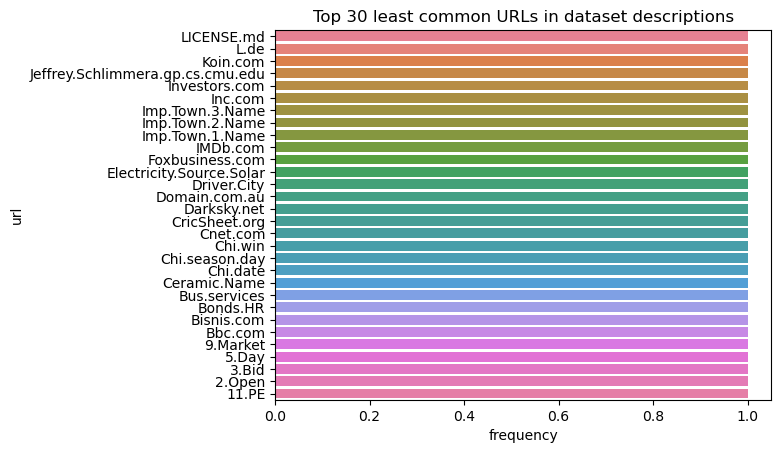

In [72]:
# plot the 30 least common URLs
k = 30
sns.barplot(x=url_freq['frequency'][-k:], y=url_freq['url'][-k:], hue=url_freq['url'][-k:])
plt.title(f'Top {k} least common URLs in dataset descriptions')
plt.show()

In [73]:
print(f"Number of unique URLs: {len(url_freq)}")

Number of unique URLs: 1626


In [74]:
# See that the URLs in the descriptions that are meaningful are actually contained in the original_data_url-s
# therefore, inspecting the data from the URLs in the descriptions is not going to be that useful. Also check plot above.
df[df['original_data_url'].map(lambda x: 'IPUMS' in x if x else False)][['name', 'original_data_url', 'openml_url']]

name  \
242  ipums_la_99-small   
245  ipums_la_98-small   
246  ipums_la_97-small   

                                                 original_data_url  \
242  https://archive.ics.uci.edu/ml/datasets/IPUMS+Census+Database   
245  https://archive.ics.uci.edu/ml/datasets/IPUMS+Census+Database   
246  https://archive.ics.uci.edu/ml/datasets/IPUMS+Census+Database   

                       openml_url  
242  https://www.openml.org/d/378  
245  https://www.openml.org/d/381  
246  https://www.openml.org/d/382